# Emotion Flip Reasoning in English Conversations

- The following project achieves the subtask III described [here](https://lcs2.in/SemEval2024-EDiReF/)
- The FAQ and requirements are listed in the following [PowerPoint](https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit#slide=id.p)

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from DrTorch.metrics import MultiHeadMetric, Accuracy, Recall, Precision
from DrTorch.wrappers import OptimizerWrapper, Criterion, MultiHeadCriterion
from DrTorch.callbacks import EarlyStopper, MultipleEarlyStoppers 

from DrTorch.utilities import DataLoaderFromPipelineStrategy
from DrTorch.utilities import plot_history
from DrTorch.model_selection import grid_search_train_validation

from sys import platform
from utilities import *
from IPython.display import display

import wandb
from functools import partial
import itertools
import joblib

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne
from models.bigBertOne import BigBertOne


import warnings
import logging

warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", message="overflow encountered in scalar add")
logging.getLogger("transformers.models.longformer.modeling_longformer").setLevel(logging.ERROR)


## Setting the device

In [2]:
print(f'PyTorch version: {torch.__version__}')

if platform == 'darwin':    
    
    print(f'Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}')
    print(f'Is MPS available? {torch.backends.mps.is_available()}')
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f'Using device: {device}')


PyTorch version: 2.2.1+cu121
Using device: cuda


In [3]:
if device.__str__() == 'cuda':
    !nvidia-smi


Fri Mar 22 23:45:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8               4W /  80W |     53MiB /  8188MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = 'local-bert'               # Directory to store bert base-uncased model
BIG_BERT_DIRECTORY = 'local-big-bert'       # Directory to store bert base-uncased model
RESULT_DIRECTORY = 'results'                # Directory to store the results
GRID_DIRECTORY = 'grid'                     # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'               # Directory to store model weights
PRED_AND_SCORES = 'pred_and_scores'         # Directory to store predictions and relative scores computed of each model 


DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
FULL_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'full_bertone_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_weights.pth')
FULL_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'full_bertone_weights.pth')
BIG_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'big_bertone_weights.pth')


# Paths for prediction and score results
PRED_AND_SCORES_PATH = os.path.join(RESULT_DIRECTORY, PRED_AND_SCORES)

# Subdirectories for prediction and score results for our models
RND_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'random')
MJR_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'majority')
FREEZED_BERTONE_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'freezed_bertone')
FULL_BERTONE_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'full_bertone')


# Patch for Random cls files 
RND_PREDICTIONS_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'predictions.csv')
RND_F1_DIALOGUE_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
RND_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
RND_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Majority cls files 
MJR_PREDICTIONS_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'predictions.csv')
MJR_F1_DIALOGUE_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
MJR_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
MJR_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Freezed BerOne files 
FREEZED_BERTONE_PREDICTIONS_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'predictions.csv')
FREEZED_BERTONE_F1_DIALOGUE_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Full BerOne files 
FULL_BERTONE_PREDICTIONS_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'predictions.csv')
FULL_BERTONE_F1_DIALOGUE_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')
 

# Bert hidden dimension
BERT_HIDDEN_DIM = 768  

# Bert batch sizes
BATCH_SIZE_FREEZED = 16
BATCH_SIZE_FULL = 2
BATCH_SIZE_BIG = 8



# Flags to interact with wandb
INTERACT_WITH_WANDB = True


##### FLAGS FOR MODEL TRAINING AND EVALUATION e AND INFERENCE

# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_FULL_BERTONE = True
FIT_BIG_BERTONE = True


# Flags for grid search
RUN_FREEZED_BERTONE_GRID_SEARCH = True
RUN_FULL_BERTONE_GRID_SEARCH = True

# Flags for running predict method
RUN_RANDOM_CLF_PREDICT = True
RUN_MAJORITY_CLf_PREDICT = True
RUN_FREEZED_BERTONE_PREDICT = True
RUN_FULL_BERTONE_PREDICT = True


# Seeds to test the robustness of the models 
SEEDS = [42, 69 ,90, 1, 77]

# Seed to use the final models in inference mode
SEED = 42

# Early stoppers Parameters
PATIENCE = 3  
DELTA = 0.001

# Maximum number of epochs for fit and grid search 
MAX_N_EPOCH = 50


## Creating Results directory

In [5]:
directories = [FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH, 
               FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
               FREEZED_BERTONE_WEIGHTS_PATH,
               FULL_BERTONE_WEIGHTS_PATH,
               RND_PRED_AND_SCORES_PATH,
               MJR_PRED_AND_SCORES_PATH,
               FREEZED_BERTONE_PRED_AND_SCORES_PATH,
               FULL_BERTONE_PRED_AND_SCORES_PATH]

create_directories(paths=directories)


## Wandb Login

In [6]:
if INTERACT_WITH_WANDB:
    wandb.login()
else:
    wandb_params = None
                    

wandb: Currently logged in as: murgiariccardo96. Use `wandb login --relogin` to force relogin



## Dataset Creation and Exploration

In [7]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Removing NaN values

In [8]:
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

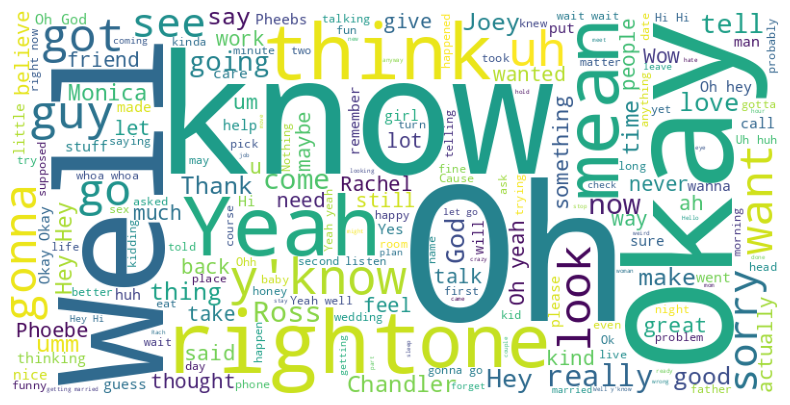

In [9]:
create_wordcloud(df, my_class_index='utterances')


### Defining same useful variables 

In [10]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX['z_emotion'] = 7
IDX_TO_EMOTIONS[7] = 'z_emotion' 


EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6,
 'z_emotion': 7}

### Taking a look to same utterance examples

In [11]:
display_dialogue(dataframe=df, utterance_id='utterance_3359')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 3359


,speakers,emotions,utterances,triggers
0,Ross,neutral,Yes that's right.,0.0
1,The Instructor,surprise,Why?,0.0
2,Ross,neutral,"I tired attacking two women, did not work.",0.0
3,The Instructor,surprise,What?!,0.0
4,Ross,neutral,"No, I mean it's okay, I mean, they're-they're ...",0.0
5,Ross,anger,"In fact, I-I-I was married to one of them.",0.0
6,The Instructor,anger,"Let me get this straight man, you attacked you...",0.0
7,Ross,surprise,"Oh, no!",0.0
8,Ross,surprise,No-no!,0.0
9,Ross,surprise,"No, I tired!",1.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Splitting the dataset 


In [12]:
torch.manual_seed(SEED)
np.random.seed(SEED)

train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df)

print("\nValidation Set: ")
display(val_df)

print("\nTest Set: ")
display(test_df)


Training Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_555,"[Phoebe, Phoebe]","[sadness, anger]","[Look, I feel really bad about how I freaked y...","[0.0, 0.0]"
utterance_3491,"[Phoebe, Eric, Phoebe, Eric]","[surprise, fear, surprise, sadness]","[You-you you had sex with Ursula?!, Uh, a litt...","[0.0, 0.0, 1.0, 0.0]"
utterance_527,"[Mona, Ross, Dr. Green, Ross]","[fear, neutral, anger, sadness]","[Oh my God! Oh my God! I'm so sorry!, Aw forge...","[0.0, 0.0, 1.0, 0.0]"
utterance_3925,"[Chandler, Chandler, Chandler, Chandler]","[neutral, neutral, neutral, disgust]","[I can blow dry it., I can put gel on it., It ...","[0.0, 0.0, 1.0, 0.0]"
utterance_2989,"[Ross, Phoebe, Ross]","[joy, joy, neutral]",[You're gonna love me so much. I got Sting tic...,"[0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3939,"[Chandler, Monica, Chandler, Ross, Chandler, R...","[joy, neutral, neutral, surprise, sadness, neu...","[Well, I feel like a snack!, Do you want some ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2523,"[Ross, Kristin, Carol, Susan, Ross, Ross, Ross]","[neutral, neutral, neutral, sadness, neutral, ...","[So, um, what do you do for a living?, Well, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
utterance_1683,"[Phoebe, Chandler, Phoebe, Chandler, Phoebe, C...","[joy, neutral, anger, surprise, sadness, surpr...","[Chandler, I found the perfect ring., Oh, that...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"



Validation Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3334,"[Rachel, Tag, Rachel]","[surprise, neutral, joy]","[Oh really?!, Yeah. Did you tell someone that ...","[0.0, 1.0, 0.0]"
utterance_652,"[Phoebe, Duncan, Phoebe, Duncan, Phoebe]","[neutral, surprise, joy, neutral, neutral]","[Hi., Phoebe!, Ta-da., Hey., Hi.]","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_172,"[Monica, Joey, Monica, Phoebe, Rachel, Joey, R...","[joy, surprise, anger, surprise, neutral, neut...","[Because we won our apartment back!, What? Ace...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3197,"[Older Scientist, Ross, Ross, Joey, Ross, Ross]","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_38,"[Chandler, Jade, Jade, Chandler]","[neutral, neutral, neutral, joy]","[What've you been up to?, Oh, you know, the us...","[0.0, 1.0, 1.0, 0.0]"
...,...,...,...,...
utterance_1415,"[Roger, Phoebe, Roger, Phoebe, Phoebe, Phoebe,...","[neutral, joy, joy, sadness, sadness, sadness,...","[What's wrong, sweetie?, Nothing, nothing., Aa...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
utterance_3610,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[disgust, sadness, sadness, joy, sadness, disg...","[Oh God, I hate my job, I hate it, I hate my j...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_1527,"[Carl, Ross, Rachel, Ross, Ross, Rachel, Ross,...","[disgust, surprise, anger, joy, neutral, neutr...","[I'm just sayin', if I see one more picture of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"



Test Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3881,"[Joey, Monica, Joey, All, Monica, Joey, Rachel...","[neutral, neutral, joy, disgust, disgust, sadn...","[Hey, y'know what a really good rainy day game...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2848,"[Janice, Chandler, Janice, Chandler, Janice, C...","[surprise, neutral, surprise, neutral, anger, ...","[Are you being British?!, No. Not anymore., Wh...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
utterance_1603,"[Rachel, Rachel, Rachel, Ross, Ross, Ross, Ros...","[sadness, sadness, sadness, neutral, neutral, ...",[I'm guess I'm just done with the whole dating...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_160,"[Mr. Tribbiani, Joey, Mr. Tribbiani, Joey]","[sadness, surprise, neutral, neutral]","[Gotta go. I miss you too, I love you, but it'...","[0.0, 0.0, 1.0, 0.0]"
utterance_1704,"[Rachel, Chandler, Rachel, Chandler, Rachel]","[joy, anger, neutral, sadness, surprise]","[Hi!, Another cheesecake came! They delivered ...","[0.0, 0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_1130,"[Phoebe, Ross, Phoebe, Chandler, Ross]","[neutral, sadness, fear, anger, neutral]","[Listen, Robert's gonna be here any second so,...","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1294,"[Chandler, Ross, Joey, Ross, Joey, Ross, Chand...","[neutral, neutral, neutral, neutral, neutral, ...","[Triskaidekaphobia., The fear of, No! No, fear...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_860,"[The Woman, Chandler, The Woman]","[joy, neutral, neutral]","[Yes! Yes! Please, just give it to me!, Yeah, ...","[0.0, 0.0, 0.0]"


### Analyzing the dataset

####  Dialogues Statistics

In [13]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


#### Speaker emotion Distribution 

In [14]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


#### Visualizing the classes distribution over the datasets

##### Emotions distribution

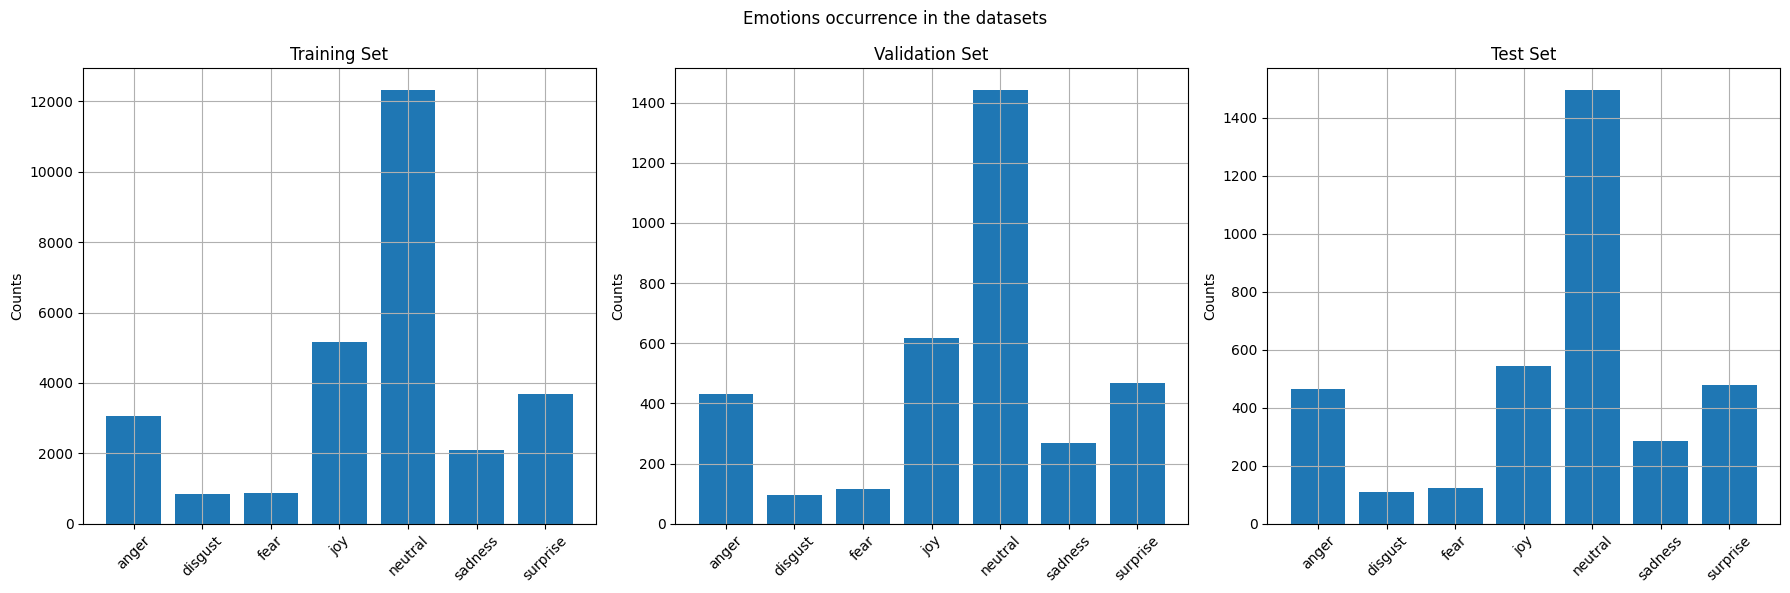

In [15]:
plot_emotion_distribution(train_df, val_df, test_df, column_name='emotions', title="Emotions occurrence in the datasets")


##### Triggers distributions

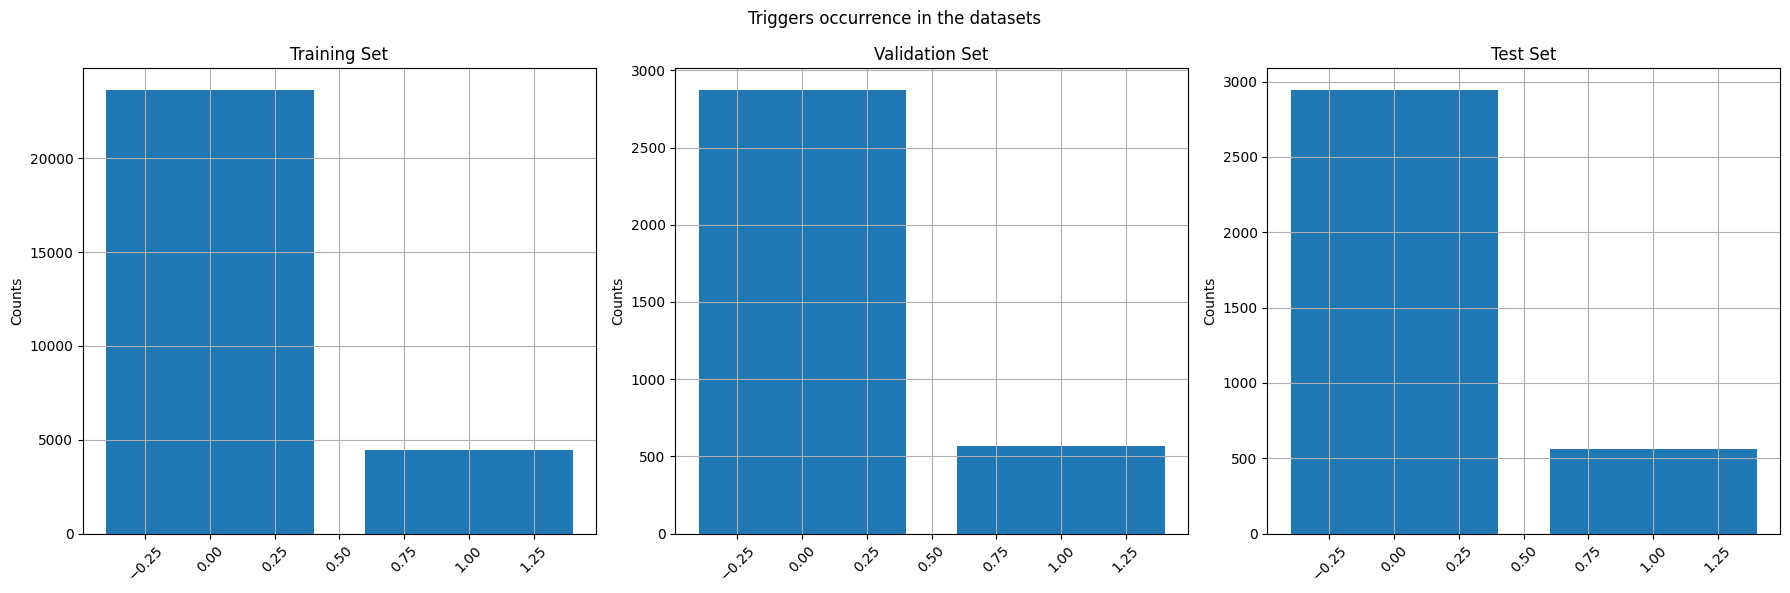

In [16]:
plot_emotion_distribution(train_df, val_df, test_df, column_name='triggers', title="Triggers occurrence in the datasets")


##### Distribution of trigger activation based on emotion 

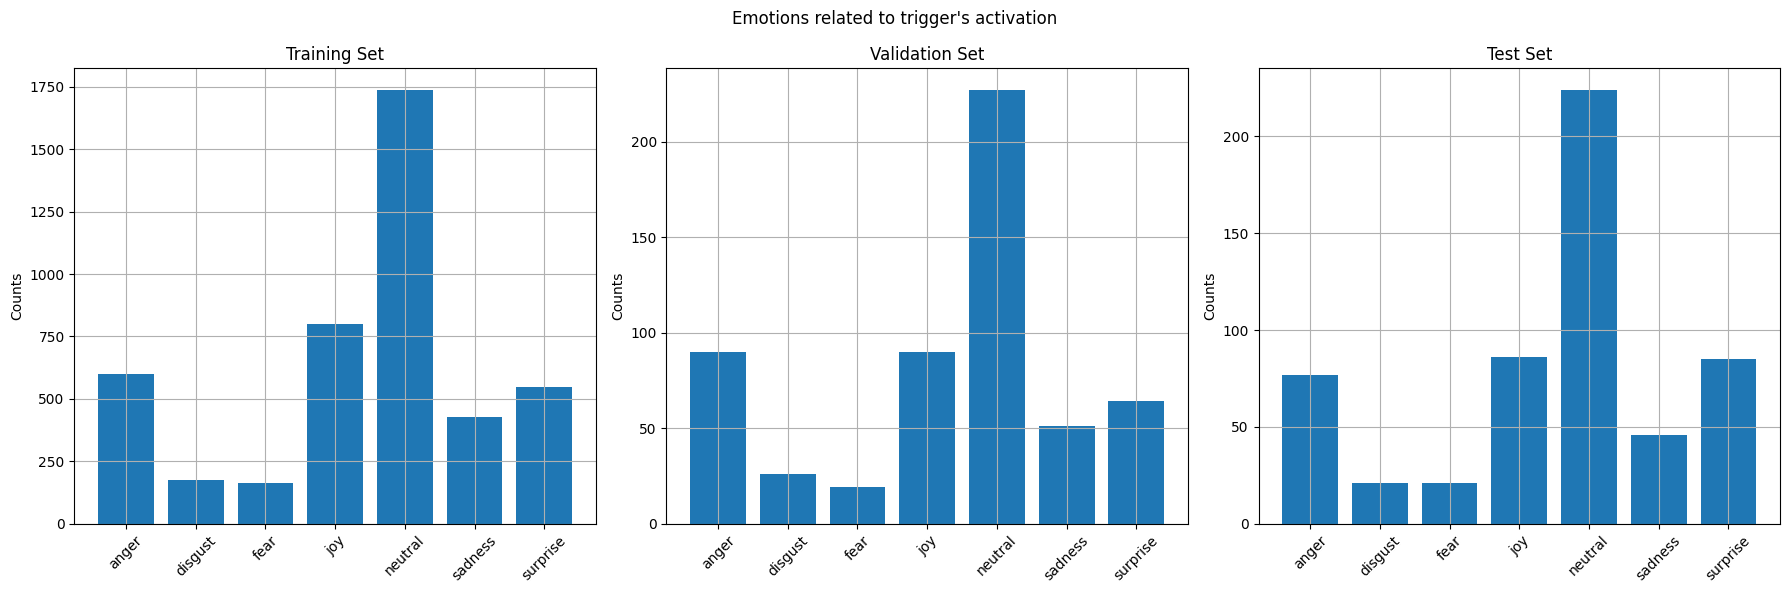

In [17]:
# How many times each emotion activates a trigger    #todo spiegare meglio 
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [18]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion] for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594732
1,1.0,3.139013
2,2.0,0.000000


## Models Experiments 

### Defining dataframe that are going to contain models results

In [19]:
f1_per_dialogue_df = pd.DataFrame()
unrolled_and_sequence_f1_df = pd.DataFrame()
emotions_f1_per_class_df = pd.DataFrame()
triggers_f1_per_class_df = pd.DataFrame()

interesting_dialogue_index_to_see = []


### Random Classifier

In [20]:
if RUN_RANDOM_CLF_PREDICT:
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(EMOTIONS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     


    random_classifier = RandomClassifier(EMOTIONS)
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
        
    random_clf_results_df = test_df.copy()
    random_clf_results_df['pred_emotions'] = pred_emotions
    random_clf_results_df['pred_triggers'] = pred_triggers
    
        
    rnd_unrolled_emotions_f1, rnd_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                             trigger_f1=trigger_f1, 
                                                                             targets_emotions=random_clf_results_df['emotions'],
                                                                             predictions_emotions=random_clf_results_df['pred_emotions'],
                                                                             targets_triggers=random_clf_results_df['triggers'],
                                                                             predictions_triggers=random_clf_results_df['pred_triggers'],
                                                                             emotion_to_index=EMOTIONS_TO_IDX)
    
    rnd_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                      trigger_f1=trigger_f1, 
                                                      targets_emotions=random_clf_results_df['emotions'],
                                                      predictions_emotions=random_clf_results_df['pred_emotions'],
                                                      targets_triggers=random_clf_results_df['triggers'],
                                                      predictions_triggers=random_clf_results_df['pred_triggers'],
                                                      emotion_to_index=EMOTIONS_TO_IDX)

    
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    rnd_emotions_f1_per_class, rnd_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                               trigger_f1=trigger_f1, 
                                                                               targets_emotions=random_clf_results_df['emotions'],
                                                                               predictions_emotions=random_clf_results_df['pred_emotions'],
                                                                               targets_triggers=random_clf_results_df['triggers'],
                                                                               predictions_triggers=random_clf_results_df['pred_triggers'],
                                                                               emotion_to_index=EMOTIONS_TO_IDX)
     
    rnd_unrolled_and_sequence_f1_df = pd.DataFrame(data={'random_cls_scores':[rnd_unrolled_emotions_f1, 
                                                                              rnd_unrolled_triggers_f1, 
                                                                              rnd_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                              rnd_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                   index=['unrolled emotion F1 scores', 
                                                          'unrolled trigger F1 scores', 
                                                          'sequence emotion F1 score', 
                                                          'sequence trigger F1 score'])            
            
    
    rnd_emotions_f1_per_class_df = pd.DataFrame(rnd_emotions_f1_per_class, index=EMOTIONS, columns=['random_scores'])
    rnd_triggers_f1_per_class_df = pd.DataFrame(rnd_triggers_f1_per_class,columns=['random_scores'] )
    
    random_clf_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    random_clf_results_df.index.name = 'index'
    rnd_f1_per_dialogue_df.index.name = 'episode'
    rnd_unrolled_and_sequence_f1_df.index.name = 'metrics'
    rnd_emotions_f1_per_class_df.index.name = 'emotions'
    rnd_triggers_f1_per_class_df.index.name = 'triggers'
    rnd_f1_per_dialogue_df.columns = ['random_'+ c_n for c_n in rnd_f1_per_dialogue_df.columns]
    
    # Saving Random cls results
    random_clf_results_df.to_csv(RND_PREDICTIONS_DF_PATH)
    rnd_f1_per_dialogue_df.to_csv(RND_F1_DIALOGUE_DF_PATH)
    rnd_unrolled_and_sequence_f1_df.to_csv(RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    rnd_emotions_f1_per_class_df.to_csv(RND_F1_PER_EMOTION_CLASSES_DF_PATH)
    rnd_triggers_f1_per_class_df.to_csv(RND_F1_PER_TRIGGER_CLASSES_DF_PATH)
    
else:
    # Loading Random cls results
    random_clf_results_df = pd.read_csv(RND_PREDICTIONS_DF_PATH, index_col=0)
    rnd_f1_per_dialogue_df = pd.read_csv(RND_F1_DIALOGUE_DF_PATH, index_col=0)
    rnd_unrolled_and_sequence_f1_df = pd.read_csv(RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    rnd_emotions_f1_per_class_df = pd.read_csv(RND_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    rnd_triggers_f1_per_class_df = pd.read_csv(RND_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)


# Merging Random results to de file result dfs        
f1_per_dialogue_df = f1_per_dialogue_df.merge(rnd_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(rnd_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(rnd_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(rnd_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)

# Extracting the two worst dialogues for the Random cls
interesting_dialogue_index_to_see += rnd_f1_per_dialogue_df.sort_values(by=['random_emotion_f1', 'random_trigger_f1']).index[:2].tolist()


### Majority Classifier

In [21]:
if RUN_MAJORITY_CLf_PREDICT:
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(EMOTIONS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     
    
    
    majority_classifier = MajorityClassifier()
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    majority_clf_results_df = test_df.copy()
    majority_clf_results_df['pred_emotions'] = pred_emotions
    majority_clf_results_df['pred_triggers'] = pred_triggers
    
    
    mjr_unrolled_emotions_f1, mjr_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                             trigger_f1=trigger_f1, 
                                                                             targets_emotions=majority_clf_results_df['emotions'],
                                                                             predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                                             targets_triggers=majority_clf_results_df['triggers'],
                                                                             predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                                             emotion_to_index=EMOTIONS_TO_IDX)
           
    mjr_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                      trigger_f1=trigger_f1, 
                                                      targets_emotions=majority_clf_results_df['emotions'],
                                                      predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                      targets_triggers=majority_clf_results_df['triggers'],
                                                      predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                      emotion_to_index=EMOTIONS_TO_IDX)
    
    
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    mjr_emotions_f1_per_class, mjr_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                              trigger_f1=trigger_f1, 
                                                                              targets_emotions=majority_clf_results_df['emotions'],
                                                                              predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                                              targets_triggers=majority_clf_results_df['triggers'],
                                                                              predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                                              emotion_to_index=EMOTIONS_TO_IDX)
    
    mjr_unrolled_and_sequence_f1_df = pd.DataFrame(data={'majority_cls_scores':[mjr_unrolled_emotions_f1, 
                                                                                mjr_unrolled_triggers_f1, 
                                                                                mjr_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                mjr_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                   index=['unrolled emotion F1 scores', 
                                                          'unrolled trigger F1 scores', 
                                                          'sequence emotion F1 score', 
                                                          'sequence trigger F1 score'])            
            
    
    mjr_emotions_f1_per_class_df = pd.DataFrame(mjr_emotions_f1_per_class, index=EMOTIONS, columns=['majority_scores'])
    mjr_triggers_f1_per_class_df = pd.DataFrame(mjr_triggers_f1_per_class,columns=['majority_scores'] )
    
    
    majority_clf_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])
    
    
    mjr_f1_per_dialogue_df.columns = ['majority_' + c_n for c_n in mjr_f1_per_dialogue_df.columns]
    majority_clf_results_df.index.name = 'index'
    mjr_f1_per_dialogue_df.index.name = 'episode'
    mjr_unrolled_and_sequence_f1_df.index.name = 'metrics'
    mjr_emotions_f1_per_class_df.index.name = 'emotions'
    mjr_triggers_f1_per_class_df.index.name = 'triggers'
    
    # Saving Majority cls results
    majority_clf_results_df.to_csv(MJR_PREDICTIONS_DF_PATH)
    mjr_f1_per_dialogue_df.to_csv(MJR_F1_DIALOGUE_DF_PATH)
    mjr_unrolled_and_sequence_f1_df.to_csv(MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    mjr_emotions_f1_per_class_df.to_csv(MJR_F1_PER_EMOTION_CLASSES_DF_PATH)
    mjr_triggers_f1_per_class_df.to_csv(MJR_F1_PER_TRIGGER_CLASSES_DF_PATH)

else:
    # Loading Majority cls results
    majority_clf_results_df = pd.read_csv(MJR_PREDICTIONS_DF_PATH, index_col=0)
    mjr_f1_per_dialogue_df = pd.read_csv(MJR_F1_DIALOGUE_DF_PATH, index_col=0)
    mjr_unrolled_and_sequence_f1_df = pd.read_csv(MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    mjr_emotions_f1_per_class_df = pd.read_csv(MJR_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    mjr_triggers_f1_per_class_df = pd.read_csv(MJR_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    

# Merging Majority results to de file result dfs        
f1_per_dialogue_df = f1_per_dialogue_df.merge(mjr_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(mjr_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(mjr_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(mjr_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)

# Extracting the two worst dialogues for the majority cls
interesting_dialogue_index_to_see += mjr_f1_per_dialogue_df.sort_values(by=['majority_emotion_f1', 'majority_trigger_f1']).index[:2].tolist()
    

### Bert Models

#### Download bert-base-uncased

In [22]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(bert_constructor=BertModel, 
                                                            bert_tokenizer_constructor=BertTokenizer, 
                                                            bert_path=BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(bert_constructor=BertModel, 
                                                            bert_tokenizer_constructor=BertTokenizer,
                                                            bert_path=BERT_DIRECTORY)


##### Data Loaders creation

In [23]:
torch.manual_seed(SEED)
np.random.seed(SEED)


dataLoaderBuilder = DataLoaderFromPipelineStrategy()

max_tokenized_length =  find_max_encoded_utterance_len(bert_tokenizer, df['utterances'])

my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length,tokenizer=bert_tokenizer)


# BertFreezed Dataloaders
train_dataloader_freezed = dataLoaderBuilder.create(data=train_df['utterances'],
                                                    labels=train_df[['emotions', 'triggers']],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=BATCH_SIZE_FREEZED,
                                                    device=device)
 
val_dataloader_freezed = dataLoaderBuilder.create(data=val_df['utterances'],
                                                  labels=val_df[['emotions', 'triggers']],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=BATCH_SIZE_FREEZED,
                                                  device=device)
 
test_dataloader_freezed = dataLoaderBuilder.create(data=test_df['utterances'],
                                                   labels=test_df[['emotions', 'triggers']],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=BATCH_SIZE_FREEZED,
                                                   device=device)   


# BertFull Dataloaders
train_dataloader_full = dataLoaderBuilder.create(data=train_df['utterances'],
                                                 labels=train_df[['emotions', 'triggers']],
                                                 shuffle=True,
                                                 data_preprocess_f=my_tokenization_f,
                                                 labels_preprocess_f=preprocess_labels,
                                                 batch_size=BATCH_SIZE_FULL,
                                                 device=device)

val_dataloader_full = dataLoaderBuilder.create(data=val_df['utterances'],
                                               labels=val_df[['emotions', 'triggers']],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=BATCH_SIZE_FULL,
                                               device=device)

test_dataloader_full = dataLoaderBuilder.create(data=test_df['utterances'],
                                                labels=test_df[['emotions', 'triggers']],
                                                shuffle=False,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=BATCH_SIZE_FULL,
                                                device=device)  
 
input_data_freezed, _ = next(iter(train_dataloader_freezed))
input_data_full, _ = next(iter(train_dataloader_full))

n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


#### Defining Metrics to use in grid search and fit section

In [24]:
##### Metrics definitions and combination

# F1s definition

# Definition of single head Unrolled F1 
unrolled_emotion_f1 = F1_Score(name='unrolled_emotions_F1',
                              mode='macro',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[7])     

unrolled_trigger_f1 = F1_Score(name='unrolled_triggers_F1',
                               mode='macro',
                               num_classes=len(padded_triggers),
                               classes_to_exclude=[2])     
           
# Combining Single head Unrolled F1 into Multi Head Metric
unrolled_multi_head_f1 = MultiHeadMetric(name='agg_unrolled_F1',
                                         metrics_functions={'emotions': unrolled_emotion_f1,
                                                            'triggers': unrolled_trigger_f1},
                                         metric_weights={'emotions': 1, 
                                                         'triggers': 1},
                                         aggregate_metrics_function=torch.mean)
 
 
# Definition of single head sequence F1 
sequence_avg_emotion_f1 = F1_Score(name='sequence_emotions_F1',
                                   mode='macro',
                                   num_classes=len(padded_emotions),
                                   classes_to_exclude=[7])     

sequence_avg_trigger_f1 = F1_Score(name='sequence_triggers_F1',
                                   mode='macro',
                                   num_classes=len(padded_triggers),
                                   classes_to_exclude=[2])     
                 
# Wrapping DrTorch F1_score into custom Metric objects that allow to compute the metrics separately for each dialog and then obtain the main 
sequence_emotion_f1 = Sentence_F1(f1_obj=sequence_avg_emotion_f1,
                                 key_to_consider='emotions')

sequence_trigger_f1 = Sentence_F1(f1_obj=sequence_avg_trigger_f1,
                                  key_to_consider='triggers')

# Combining Single head sentence F1 into Multi Head Metric
sentence_multi_head_f1 = MultiHeadMetric(name='agg_sequence_F1',
                                         metrics_functions={'emotions': sequence_emotion_f1,
                                                            'triggers': sequence_trigger_f1},
                                         metric_weights={'emotions': 1, 
                                                         'triggers': 1},
                                         aggregate_metrics_function=torch.mean)


# Accuracy definition
emotion_accuracy = Accuracy(name='emotions_accuracy',
                            num_classes=len(padded_emotions),
                            classes_to_exclude=[7])     

trigger_accuracy = Accuracy(name='triggers_accuracy',
                            num_classes=len(padded_triggers),
                            classes_to_exclude=[2])     

multi_head_accuracy = MultiHeadMetric(name='agg_avg_accuracy',
                                      metrics_functions={'emotions': emotion_accuracy,
                                                         'triggers': trigger_accuracy},
                                      metric_weights={'emotions': 1, 
                                                      'triggers': 1},
                                      aggregate_metrics_function=torch.mean)


# Recall definition
emotion_recall = Recall(name='emotions_recall',
                        num_classes=len(padded_emotions),
                        classes_to_exclude=[7])     

trigger_recall = Recall(name='triggers_recall',
                        num_classes=len(padded_triggers),
                        classes_to_exclude=[2])     

multi_head_recall = MultiHeadMetric(name='agg_avg_recall',
                                    metrics_functions={'emotions': emotion_recall,
                                                       'triggers': trigger_recall},
                                    metric_weights={'emotions': 1, 
                                                    'triggers': 1},
                                    aggregate_metrics_function=torch.mean)


# Precision definition
emotion_precision = Precision(name='emotions_precision',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[7])     

trigger_precision = Precision(name='triggers_precision',
                              num_classes=len(padded_triggers),
                              classes_to_exclude=[2])     
      
multi_head_precision = MultiHeadMetric(name='agg_avg_precision',
                                       metrics_functions={'emotions': emotion_precision,
                                                          'triggers': trigger_precision},
                                       metric_weights={'emotions': 1, 
                                                        'triggers': 1},
                                       aggregate_metrics_function=torch.mean)
   

#### Defining same useful functions

In [25]:
# Function to send a sample to wandb during the training process of the best models 
def send_a_predicted_sample_to_wandb(model: BertOne):
    """
    An auxiliary function used to send Wandb the predictions of an element extracted from the test set during training 
    to monitor how the model's predictions improve during the during various epochs  
        
    """
    
    model.eval()

    sample_to_send = test_df.iloc[0].copy()
    input  = next(iter(test_dataloader_freezed))[0]
    input = {key:input[key][0].unsqueeze(0).to(device) for key in input.keys()}
    prediction = model(input)
    prediction = {key: torch.argmax(prediction[key], dim=-1).view(-1).detach().cpu() for key in prediction.keys()}
    
    table_data = []
    for column_value in sample_to_send:
        table_data.append(column_value)
    
    new_df = pd.DataFrame(table_data).transpose()
    new_df.columns = sample_to_send.index
    
    new_df['pred_emotion'] = [IDX_TO_EMOTIONS[emotion] for emotion in prediction['emotions'].tolist()][: len(new_df)]
    new_df['pred_emotion'] = new_df['pred_emotion'].apply(lambda x: str(x))

    new_df['pred_triggers'] = prediction['triggers'].tolist()[: len(new_df)]
    
    return {'sample_of_predictions': wandb.Table(dataframe=new_df)}


# DataLoaderFromPipelineStrategy.create() unpacking parameter logic
def my_logic(param, _):
    """
    This function is an auxiliary function for the creation of dataloaders inside the grid search 
    
    """
    if param == 'data_preprocess_f':
        max_tokenized_length = find_max_encoded_utterance_len(bert_tokenizer, df['utterances'])
        additional_parm  = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)
    elif param == 'labels_preprocess_f':
        additional_parm = preprocess_labels
    elif param == 'pin_memory':
        additional_parm = True
    elif param == 'num_workers':
        additional_parm = 10
    elif param == 'sample_preprocess_f':
        additional_parm = None
    elif param == 'label_preprocess_f':
        additional_parm = None
    else:
        raise AttributeError (f'DataLoaderFromPipelineStrategy.create() require attribute {param}')
    
    return additional_parm

    

#### Freezed BertOne

##### Grid Search Freezed BertOne 

In [25]:
if RUN_FREEZED_BERTONE_GRID_SEARCH:
    
    #creating Wandb config params 
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
    else:
        wandb_params = None

    hyperparameters_key_to_save = ['criterion', 'name']
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-3}', optimizer_partial_params={'lr':1e-3})]

    # Defining single Head Criterion
    emotion_criterion = Criterion(name='emotion_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)

    trigger_criterion = Criterion(name='trigger_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    # Defining single Head Criterion that use class weights
    emotion_criterion_w_ce = Criterion(name='emotion_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(emotion_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)

    trigger_criterion_w_ce = Criterion(name='trigger_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(trigger_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)


    # Aggregate single head criteria into a multi-head criteria 
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion,
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions':1, 
                                                            'triggers':1},
                                              reduction_function=torch.mean)

    
    # Aggregate single head criteria that use class weights into a multi-head criteria
    multi_head_criterion_w_cw = MultiHeadCriterion(name='CE_loss_w_cw',
                                                   loss_functions={'emotions': emotion_criterion_w_ce,
                                                                   'triggers': trigger_criterion_w_ce},
                                                   loss_weights={'emotions':1, 
                                                                 'triggers':1},
                                                   reduction_function=torch.mean)

    
    # List of the criteria to test
    criteria = [multi_head_criterion_w_cw,  multi_head_criterion]


    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE, 
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    # Aggregate the single early stoppers into a multiple early stoppers 
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                      'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    
    
    model_hyperparameters_to_test=[{'model_class': BertOne,
                                    'bert_model': bert_model,
                                    'n_emotions': len(padded_emotions),
                                    'n_triggers': len(padded_triggers),
                                    'cls_input_size': n_token_per_utterance * BERT_HIDDEN_DIM,
                                    'hidden_dim': 512,
                                    'freeze_bert_weights': True,
                                    'name': 'Freezed Bertone'}]

    training_hyperparameters_to_test = [{'num_epochs': MAX_N_EPOCH,
                                         'optimizer': optimizer,
                                         'batch_size': BATCH_SIZE_FREEZED,
                                         'criterion': current_criterion,
                                         'early_stopper': multiple_stopper,
                                         'interaction_with_wandb': INTERACT_WITH_WANDB, 
                                         'metrics': [unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                         } for optimizer, current_criterion in itertools.product(optimizers, criteria)]


    dataLoaderBuilder = DataLoaderFromPipelineStrategy(logic=partial(my_logic))
        
    grid_search_train_validation(train_data=(train_df['utterances'], train_df[['emotions', 'triggers']]),
                                 val_data=(val_df['utterances'], val_df[['emotions', 'triggers']]),
                                 dataloader_builder=dataLoaderBuilder,
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 device=device,
                                 path_to_save_grid_search_results=FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH,
                                 seeds=SEEDS,
                                 save_loss_values=True,
                                 wandb_params=wandb_params)


100%|██████████| 2/2 [17:48:02<00:00, 32041.46s/it] 


##### Verifying the robustness of the tested models 

###### Visualizing grid search results for Freezed Bertone  

In [26]:
freezed_grid_result_df =  joblib.load(FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH)
freezed_grid_result_df


,criterion,name,time,seed,train_loss,val_loss,agg_unrolled_F1_train,agg_unrolled_F1_val,unrolled_emotions_F1_train,unrolled_emotions_F1_val,...,emotions_recall_train,emotions_recall_val,triggers_recall_train,triggers_recall_val,agg_avg_precision_train,agg_avg_precision_val,emotions_precision_train,emotions_precision_val,triggers_precision_train,triggers_precision_val
0,CE_loss_w_cw,Freezed Bertone,8000.340133,42,0.197312,0.639424,0.833100,0.625461,0.944005,0.734689,...,0.431411,0.381157,0.288057,0.250340,0.343998,0.290811,0.418842,0.361566,0.282269,0.222342
1,CE_loss_w_cw,Freezed Bertone,6029.239505,69,0.380046,0.916848,0.777311,0.603602,0.955465,0.721462,...,0.430940,0.364778,0.274965,0.248772,0.328785,0.284684,0.424419,0.373368,0.256658,0.220613
2,CE_loss_w_cw,Freezed Bertone,6633.182054,90,0.297330,0.732376,0.804364,0.628640,0.952344,0.731525,...,0.430348,0.371179,0.274436,0.248835,0.340757,0.293612,0.423595,0.370487,0.270895,0.224833
3,CE_loss_w_cw,Freezed Bertone,6623.510858,1,1.657016,2.143196,0.699495,0.587381,0.961262,0.737885,...,0.432442,0.373168,0.215712,0.211546,0.323569,0.279487,0.425483,0.371567,0.263154,0.224602
4,CE_loss_w_cw,Freezed Bertone,5436.061272,77,0.236062,0.692674,0.806833,0.600803,0.914860,0.707727,...,0.420132,0.361133,0.290887,0.253267,0.336911,0.290085,0.416678,0.367863,0.270573,0.221788
5,CE_loss,Freezed Bertone,4824.316406,42,0.238251,0.520385,0.757551,0.616691,0.966397,0.745677,...,0.429252,0.363743,0.257304,0.244675,0.356419,0.312676,0.430843,0.386702,0.273647,0.230138
6,CE_loss,Freezed Bertone,7357.993915,69,0.208663,0.513813,0.799477,0.648105,0.990786,0.770054,...,0.435576,0.375456,0.248687,0.232744,0.348964,0.301919,0.435375,0.385941,0.275585,0.229937
7,CE_loss,Freezed Bertone,7937.568130,90,0.151494,0.475351,0.818063,0.667230,0.985711,0.775551,...,0.435159,0.377081,0.237682,0.224527,0.364041,0.311889,0.433565,0.389066,0.296921,0.236586
8,CE_loss,Freezed Bertone,5510.391844,1,0.149402,0.465131,0.822784,0.669150,0.970986,0.755619,...,0.431314,0.370443,0.240251,0.223467,0.365464,0.311405,0.430837,0.383969,0.300092,0.238842
9,CE_loss,Freezed Bertone,5552.757552,77,0.280072,0.554372,0.738442,0.606461,0.979277,0.752266,...,0.432761,0.365726,0.230151,0.223015,0.339170,0.297653,0.433092,0.388261,0.273032,0.231605


###### Computing experiment statistics

In [27]:
# freezed_grid_result_df['criterion'] = freezed_grid_result_df['criterion'].apply(lambda x: x.name) # todo decomentare prima di riconsegnare 
column_to_consider = [column_name for column_name in freezed_grid_result_df.keys() if column_name not in ['criterion', 'name', 'seed']]
statistics_df = freezed_grid_result_df.groupby('criterion')[column_to_consider].agg(['mean', 'std'])

pd.set_option('display.max_columns', None) 
statistics_df

time              train_loss            val_loss  \
                     mean          std       mean       std      mean   
criterion                                                               
CE_loss       6236.605569  1336.074532   0.205576  0.056363  0.505810   
CE_loss_w_cw  6544.466764   952.327084   0.553553  0.620704  1.024904   

                       agg_unrolled_F1_train           agg_unrolled_F1_val  \
                   std                  mean       std                mean   
criterion                                                                    
CE_loss       0.036115              0.787263  0.037503            0.641527   
CE_loss_w_cw  0.633797              0.784221  0.051314            0.609178   

                       unrolled_emotions_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.028781                   0.978631  0.010080   
CE_loss_w_cw  0.017466                   0.945587  0.018273   

             unrolled_emotions_F1_val           unrolled_triggers_F1_train  \
                                 mean       std                       mean   
criterion                                                                    
CE_loss                      0.759834  0.012519                   0.665844   
CE_loss_w_cw                 0.726658  0.012243                   0.696019   

                       unrolled_triggers_F1_val            \
                   std                     mean       std   
criterion                                                   
CE_loss       0.022160                 0.580546  0.005193   
CE_loss_w_cw  0.066714                 0.552356  0.009928   

             agg_sequence_F1_train           agg_sequence_F1_val            \
                              mean       std                mean       std   
criterion                                                                    
CE_loss                   0.518569  0.023146            0.442087  0.013605   
CE_loss_w_cw              0.537939  0.044456            0.429968  0.010897   

             sequence_emotions_F1_train           sequence_emotions_F1_val  \
                                   mean       std                     mean   
criterion                                                                    
CE_loss                        0.493180  0.007227                 0.387435   
CE_loss_w_cw                   0.475379  0.014030                 0.370043   

                       sequence_triggers_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.006737                   0.587707  0.021707   
CE_loss_w_cw  0.010496                   0.638451  0.069478   

             sequence_triggers_F1_val           agg_avg_accuracy_train  \
                                 mean       std                   mean   
criterion                                                                
CE_loss                      0.528376  0.008503               0.896246   
CE_loss_w_cw                 0.520055  0.010954               0.854800   

                       agg_avg_accuracy_val           emotions_accuracy_train  \
                   std                 mean       std                    mean   
criterion                                                                       
CE_loss       0.026664             0.772738  0.019838                0.978818   
CE_loss_w_cw  0.018236             0.689555  0.030685                0.943924   

                       emotions_accuracy_val            \
                   std                  mean       std   
criterion                                                
CE_loss       0.009894              0.799767  0.009137   
CE_loss_w_cw  0.018571              0.760896  0.014660   

             triggers_accuracy_train           triggers_accuracy_val  \
             

##### Creating Freezed BertOne

In [28]:
torch.manual_seed(SEED)
np.random.seed(SEED)

freezed_bertOne = BertOne(bert_model=bert_model,
                          n_emotions=len(padded_emotions),
                          n_triggers=len(padded_triggers),
                          cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                          hidden_dim=512,
                          freeze_bert_weights=True,
                          name='FreezedBertOne').to(device)


#####   Visualizing Net Structure 

In [29]:
freezed_bertOne.visualize_network_graph(input=input_data_freezed, 
                                        input_names=['tokenized utterances', 'token id', 'attention mask'],
                                        output_names=['emotions','triggers'])


##### Visualizing the summary 

In [30]:
freezed_bertOne.summary(input_data_freezed, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1             [16, 380, 768]      23,440,896
              Embedding-2             [16, 380, 768]           1,536
              Embedding-3             [16, 380, 768]         393,216
              LayerNorm-4             [16, 380, 768]           1,536
                Dropout-5             [16, 380, 768]               0
         BertEmbeddings-6             [16, 380, 768]               0
                 Linear-7             [16, 380, 768]         590,592
                 Linear-8             [16, 380, 768]         590,592
                 Linear-9             [16, 380, 768]         590,592
               Dropout-10         [16, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12             [16, 380, 768]         590,592
               Dropout-13         

##### Fitting the best Freezed BertOne

In [31]:
if FIT_FREEZED_BERTONE:
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)
    
    
    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                       'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    

    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={1e-3}', 
                                 optimizer_partial_params={'lr': 1e-3})  
    
    
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
    
    freezed_bertOne_history = freezed_bertOne.fit(train_loader=train_dataloader_freezed,
                                                  val_loader=val_dataloader_freezed,
                                                  criterion=multi_head_criterion,
                                                  metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                                  optimizer=optimizer,
                                                  early_stopper=multiple_stopper,
                                                  num_epochs=MAX_N_EPOCH,
                                                  verbose=2,
                                                  interaction_with_wandb=INTERACT_WITH_WANDB,
                                                  interaction_function_with_wandb=send_a_predicted_sample_to_wandb)

    torch.save(freezed_bertOne.state_dict(), FREEZED_BERTONE_WEIGHTS_PATH)

else:
    freezed_bertOne.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))
    
    freezed_bertOne_history = None 
    

wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch 1/50                                            Time: 609.6790s
Metric/Loss                   Training                 Validation               
----------------------------------------------------------------------
Ce_loss                       0.4271927504             0.6451935532             
Unrolled_emotions_f1          0.6752874308             0.5187945064             
Unrolled_triggers_f1          0.6133325276             0.5494814971             
Agg_unrolled_f1               0.6443099792             0.5341380018             
Sequence_emotions_f1          0.3319372342             0.2776077098             
Sequence_triggers_f1          0.5395386083             0.4965428261             
Agg_sequence_f1               0.4357379213             0.3870752679             
Emotions_accuracy             0.7368683629             0.6171079430             
Triggers_accuracy             0.8493692538             0.7861507128             
Agg_avg_accuracy              0.7931188084       

##### Visualizing training history  

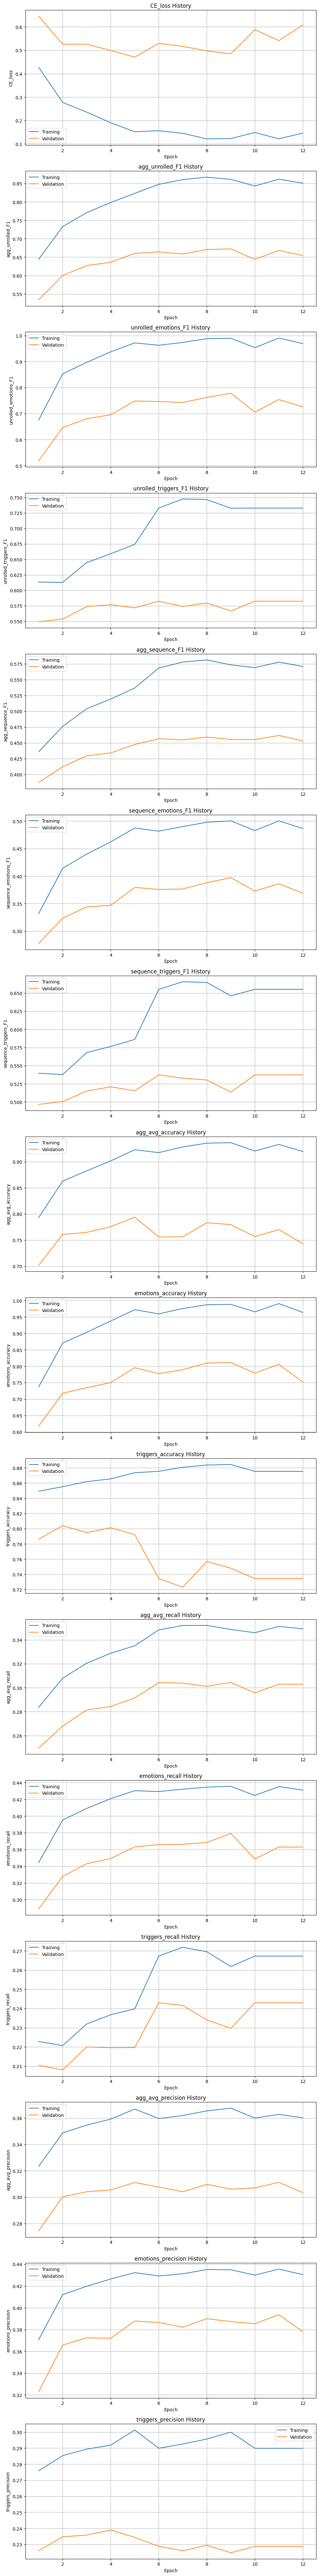

In [32]:
if FIT_FREEZED_BERTONE:
    plot_history(freezed_bertOne_history)
else:
    print('To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True')
    

##### Freezed BertOne in inference mode and scores calculus

In [33]:
if RUN_FREEZED_BERTONE_PREDICT:

    freezed_bertOne.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))

    pred = freezed_bertOne.predict(data=test_dataloader_freezed, model_output_function_transformation=torch.argmax)
    
    freezed_bertOne_results_df = test_df.copy()
    freezed_bertOne_results_df['pred_emotions'] = [[IDX_TO_EMOTIONS[emotion] for emotion in utterance_emotions] for utterance_emotions in pred['emotions'].tolist()]
    freezed_bertOne_results_df['pred_triggers'] =  pred['triggers'].tolist()
    
    max_length = len(freezed_bertOne_results_df.iloc[0]['pred_emotions'])
    freezed_bertOne_results_df['padded_emotions'] = freezed_bertOne_results_df['emotions'].apply(lambda x: x + ['z_emotion'] * (max_length - len(x)))
    freezed_bertOne_results_df['padded_triggers'] = freezed_bertOne_results_df['triggers'].apply(lambda x: x + [2] * (max_length - len(x)))
    
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(padded_emotions),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[7])     
    
    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(padded_triggers),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[2])     
    
    
    freezed_bertOne_unrolled_emotions_f1, freezed_bertOne_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                     trigger_f1=trigger_f1, 
                                                                                                     targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                                                     predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                                                     targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                                                     predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                                                     emotion_to_index=EMOTIONS_TO_IDX)
     
    freezed_bertOne_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                                  trigger_f1=trigger_f1, 
                                                                  targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                  predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                  targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                  predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                  emotion_to_index=EMOTIONS_TO_IDX)
    
    # Setting metric objects in none mode in order to compute the score for each class
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    freezed_bertOne_emotions_f1_per_class, freezed_bertOne_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                       trigger_f1=trigger_f1, 
                                                                                                       targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                                                       predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                                                       targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                                                       predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                                                       emotion_to_index=EMOTIONS_TO_IDX)
     
    freezed_bertOne_results_df.drop(columns=['padded_emotions', 'padded_triggers'], inplace=True)
    freezed_bertOne_results_df['pred_emotions'] = freezed_bertOne_results_df.apply(lambda row: row['pred_emotions'][:len(row['emotions'])], axis=1)
    freezed_bertOne_results_df['pred_triggers'] = freezed_bertOne_results_df.apply(lambda row: row['pred_triggers'][:len(row['triggers'])], axis=1)
    
    
    
    
    freezed_bertOne_unrolled_and_sequence_f1_df = pd.DataFrame(data={'freezed_bertone_cls_scores':[freezed_bertOne_unrolled_emotions_f1, 
                                                                                                   freezed_bertOne_unrolled_triggers_f1, 
                                                                                                   freezed_bertOne_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                                   freezed_bertOne_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                               index=['unrolled emotion F1 scores', 
                                                                      'unrolled trigger F1 scores', 
                                                                      'sequence emotion F1 score', 
                                                                      'sequence trigger F1 score'])            
            
    
    freezed_bertOne_emotions_f1_per_class_df = pd.DataFrame(freezed_bertOne_emotions_f1_per_class, index=EMOTIONS, columns=['freezed_bertOne_scores'])
    freezed_bertOne_triggers_f1_per_class_df = pd.DataFrame(freezed_bertOne_triggers_f1_per_class,columns=['freezed_bertOne_scores'] )
    
    freezed_bertOne_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    
    freezed_bertOne_results_df.index.name = 'index'
    freezed_bertOne_f1_per_dialogue_df.index.name = 'episode'
    freezed_bertOne_unrolled_and_sequence_f1_df.index.name = 'metrics'
    freezed_bertOne_emotions_f1_per_class_df.index.name = 'emotions'
    freezed_bertOne_triggers_f1_per_class_df.index.name = 'triggers'
    freezed_bertOne_f1_per_dialogue_df.columns = ['freezed_bertOne_'+ c_n for c_n in freezed_bertOne_f1_per_dialogue_df.columns]

    
    # Saving Freezed BertOne results
    freezed_bertOne_results_df.to_csv(FREEZED_BERTONE_PREDICTIONS_DF_PATH)
    freezed_bertOne_f1_per_dialogue_df.to_csv(FREEZED_BERTONE_F1_DIALOGUE_DF_PATH)
    freezed_bertOne_unrolled_and_sequence_f1_df.to_csv(FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    freezed_bertOne_emotions_f1_per_class_df.to_csv(FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH)
    freezed_bertOne_triggers_f1_per_class_df.to_csv(FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH)
   
else:
    # Loading Freezed bertOne results  
    freezed_bertOne_results_df = pd.read_csv(FREEZED_BERTONE_PREDICTIONS_DF_PATH, index_col=0)
    freezed_bertOne_f1_per_dialogue_df = pd.read_csv(FREEZED_BERTONE_F1_DIALOGUE_DF_PATH, index_col=0)
    freezed_bertOne_unrolled_and_sequence_f1_df = pd.read_csv(FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    freezed_bertOne_emotions_f1_per_class_df = pd.read_csv(FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    freezed_bertOne_triggers_f1_per_class_df = pd.read_csv(FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    
    
# Merging Freezed BertOne results to de file result dfs    
f1_per_dialogue_df = f1_per_dialogue_df.merge(freezed_bertOne_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(freezed_bertOne_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(freezed_bertOne_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(freezed_bertOne_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)


# Extracting the two worst dialogues for Freezed BertOne 
interesting_dialogue_index_to_see += freezed_bertOne_f1_per_dialogue_df.sort_values(by=['freezed_bertOne_emotion_f1', 'freezed_bertOne_trigger_f1']).index[:2].tolist()


#### Full BertOne

##### Grid Search Full BertOne 

In [34]:
if RUN_FULL_BERTONE_GRID_SEARCH:
    
    #creating Wandb config params 
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
    else:
        wandb_params = None

    hyperparameters_key_to_save = ['criterion', 'name']
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={2*(10**(-5))}', optimizer_partial_params={'lr':2*(10**(-5))})]

    # Defining single Head Criterion
    emotion_criterion = Criterion(name='emotion_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)

    trigger_criterion = Criterion(name='trigger_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    # Defining single Head Criterion that use class weights
    emotion_criterion_w_cw = Criterion(name='emotion_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(emotion_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)

    trigger_criterion_w_cw = Criterion(name='trigger_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(trigger_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)


    # Aggregate single head criteria into a multi-head criteria
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion,
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions':1, 
                                                            'triggers':1},
                                              reduction_function=torch.mean)

    
    # Aggregate single head criteria that use class weights into a multi-head criteria
    multi_head_criterion_w_cw = MultiHeadCriterion(name='CE_loss_w_cw',
                                                   loss_functions={'emotions': emotion_criterion_w_cw,
                                                                   'triggers': trigger_criterion_w_cw},
                                                   loss_weights={'emotions': 1, 
                                                                 'triggers': 1},
                                                   reduction_function=torch.mean)

    
    # List of the criteria to test
    criteria = [multi_head_criterion_w_cw, multi_head_criterion]


    # Early Stopper definition
    early_stopper = EarlyStopper(monitor='agg_unrolled_F1',
                                 patience=PATIENCE, 
                                 delta=DELTA, 
                                 mode='max',
                                 restore_weights=True)
    

    model_hyperparameters_to_test=[{'model_class': BertOne,
                                    'bert_model': bert_model,
                                    'n_emotions': len(padded_emotions),
                                    'n_triggers': len(padded_triggers),
                                    'cls_input_size': n_token_per_utterance * BERT_HIDDEN_DIM,
                                    'hidden_dim': 512,
                                    'freeze_bert_weights': False,
                                    'name': 'FullBertone'}]

    training_hyperparameters_to_test = [{'num_epochs': MAX_N_EPOCH,
                                         'optimizer': optimizer,
                                         'batch_size': BATCH_SIZE_FULL,
                                         'criterion': current_criterion,
                                         'early_stopper': early_stopper,
                                         'metrics': [unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                         'interaction_with_wandb': INTERACT_WITH_WANDB,
                                         } for optimizer, current_criterion in itertools.product(optimizers, criteria)]


    dataLoaderBuilder = DataLoaderFromPipelineStrategy(logic=partial(my_logic))


    grid_search_train_validation(train_data=(train_df['utterances'], train_df[['emotions', 'triggers']]),
                                 val_data=(val_df['utterances'], val_df[['emotions', 'triggers']]),
                                 dataloader_builder=dataLoaderBuilder,
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 device=device,
                                 path_to_save_grid_search_results=FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
                                 seeds=SEEDS,
                                 save_loss_values=True,
                                 wandb_params=wandb_params)


100%|██████████| 2/2 [19:47:44<00:00, 35632.23s/it] 


##### Verifying the robustness of the tested models

###### Visualizing grid search results for Freezed Bertone  


In [35]:
Full_grid_result_df =  joblib.load(FULL_BERTONE_GRID_SEARCH_RESULTS_PATH)
Full_grid_result_df


,criterion,name,time,seed,train_loss,val_loss,agg_unrolled_F1_train,agg_unrolled_F1_val,unrolled_emotions_F1_train,unrolled_emotions_F1_val,unrolled_triggers_F1_train,unrolled_triggers_F1_val,agg_sequence_F1_train,agg_sequence_F1_val,sequence_emotions_F1_train,sequence_emotions_F1_val,sequence_triggers_F1_train,sequence_triggers_F1_val,agg_avg_accuracy_train,agg_avg_accuracy_val,emotions_accuracy_train,emotions_accuracy_val,triggers_accuracy_train,triggers_accuracy_val,agg_avg_recall_train,agg_avg_recall_val,emotions_recall_train,emotions_recall_val,triggers_recall_train,triggers_recall_val,agg_avg_precision_train,agg_avg_precision_val,emotions_precision_train,emotions_precision_val,triggers_precision_train,triggers_precision_val
0,CE_loss_w_cw,FullBertone,5311.074626,42,0.226014,0.638060,0.832369,0.631007,0.938792,0.703511,0.725945,0.558502,0.571009,0.446657,0.478713,0.371463,0.663304,0.521851,0.895713,0.717195,0.941166,0.751818,0.850260,0.682572,0.354367,0.308937,0.431020,0.372303,0.277714,0.245571,0.345600,0.287344,0.416957,0.352719,0.274244,0.221969
1,CE_loss_w_cw,FullBertone,7285.313036,69,0.178650,0.656044,0.857320,0.639544,0.953450,0.721283,0.761190,0.557804,0.595072,0.449984,0.489029,0.377725,0.701115,0.522242,0.911214,0.712831,0.960445,0.762584,0.861984,0.663078,0.362312,0.313390,0.433195,0.375188,0.291429,0.251592,0.350615,0.292591,0.421390,0.361859,0.279840,0.223324
2,CE_loss_w_cw,FullBertone,6521.602751,90,0.170134,0.660915,0.840642,0.624976,0.977979,0.759026,0.703306,0.490926,0.585039,0.434701,0.494236,0.388025,0.675841,0.481377,0.878555,0.663515,0.974948,0.785278,0.782161,0.541752,0.366129,0.312255,0.434857,0.375976,0.297400,0.248534,0.345351,0.298452,0.430453,0.380232,0.260249,0.216672
3,CE_loss_w_cw,FullBertone,4546.058675,1,0.242695,0.622781,0.793337,0.602733,0.901040,0.667847,0.685634,0.537619,0.553050,0.442647,0.462263,0.360567,0.643836,0.524727,0.848710,0.662496,0.910341,0.717195,0.787079,0.607797,0.356027,0.313670,0.427176,0.370007,0.284878,0.257333,0.330076,0.280221,0.403980,0.337032,0.256173,0.223409
4,CE_loss_w_cw,FullBertone,5195.941859,77,0.239457,0.719331,0.839288,0.661478,0.964848,0.742286,0.713728,0.580670,0.562566,0.455210,0.485746,0.372232,0.639387,0.538189,0.909949,0.753710,0.961122,0.779168,0.858777,0.728251,0.349334,0.304228,0.432177,0.364420,0.266490,0.244035,0.352962,0.306052,0.427254,0.384136,0.278671,0.227968
5,CE_loss,FullBertone,11048.910723,42,0.081267,0.531266,0.911099,0.680368,0.998952,0.795565,0.823246,0.565172,0.623470,0.462475,0.506841,0.404362,0.740099,0.520587,0.956275,0.771603,0.999145,0.832412,0.913406,0.710794,0.364893,0.308271,0.437277,0.376008,0.292509,0.240533,0.372219,0.312636,0.437265,0.402189,0.307173,0.223083
6,CE_loss,FullBertone,8611.102294,69,0.094862,0.470056,0.879977,0.669255,0.997732,0.772009,0.762222,0.566502,0.589121,0.451170,0.505657,0.392670,0.672585,0.509669,0.947580,0.785714,0.997755,0.814664,0.897406,0.756765,0.352897,0.298980,0.436888,0.370750,0.268907,0.227210,0.372800,0.309676,0.437119,0.393938,0.308481,0.225413
7,CE_loss,FullBertone,8632.921214,90,0.094385,0.495680,0.894167,0.674581,0.997508,0.780794,0.790826,0.568368,0.605296,0.459737,0.505208,0.391061,0.705384,0.528412,0.950093,0.771312,0.997185,0.818446,0.903000,0.724178,0.358882,0.305561,0.436829,0.372944,0.280936,0.238179,0.371426,0.310042,0.437080,0.395985,0.305771,0.224099
8,CE_loss,FullBertone,7926.359216,1,0.108700,0.503493,0.889372,0.669686,0.993703,0.767481,0.785042,0.571891,0.604119,0.466216,0.503678,0.397499,0.704559,0.534933,0.944142,0.764475,0.992695,0.800116,0.895588,0.728833,0.359931,0.309576,0.436688,0.380396,0.283174,0.238755,0.367304,0.302920,0.435555,0.380552,0.299053,0.225288
9,CE_loss,FullBertone,5998.174247,77,0.133145,0.488114,0.867613,0.670436,0.988304,0.762679,0.746922,0.578193,0.580837,0.459839,0.498111,0.380990,0.663563,0.538687,0.934164,0.760983,0.985924,0.793134,0.882403,0.728833,0.352697,0.304351,0.434792,0.366432,0.270603,0.242270,0.364617,0.311241,0.435076,0.395188,0.29

###### Computing experiment statistics


In [36]:
Full_grid_result_df['criterion'] = Full_grid_result_df['criterion'].apply(lambda x: x.name)
column_to_consider = [column_name for column_name in Full_grid_result_df.keys() if column_name not in ['criterion', 'name', 'seed']]
statistics_df = Full_grid_result_df.groupby('criterion')[column_to_consider].agg(['mean', 'std'])

pd.set_option('display.max_columns', None) 
statistics_df

time              train_loss            val_loss  \
                     mean          std       mean       std      mean   
criterion                                                               
CE_loss       8443.493539  1809.640060   0.102472  0.019702  0.497722   
CE_loss_w_cw  5771.998189  1106.712242   0.211390  0.034480  0.659426   

                       agg_unrolled_F1_train           agg_unrolled_F1_val  \
                   std                  mean       std                mean   
criterion                                                                    
CE_loss       0.022474              0.888446  0.016221            0.672865   
CE_loss_w_cw  0.036748              0.832591  0.023781            0.631948   

                       unrolled_emotions_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.004698                   0.995240  0.004347   
CE_loss_w_cw  0.021405                   0.947222  0.029577   

             unrolled_emotions_F1_val           unrolled_triggers_F1_train  \
                                 mean       std                       mean   
criterion                                                                    
CE_loss                      0.775706  0.012954                   0.781651   
CE_loss_w_cw                 0.718791  0.035376                   0.717960   

                       unrolled_triggers_F1_val            \
                   std                     mean       std   
criterion                                                   
CE_loss       0.029195                 0.570025  0.005218   
CE_loss_w_cw  0.028329                 0.545104  0.033901   

             agg_sequence_F1_train           agg_sequence_F1_val            \
                              mean       std                mean       std   
criterion                                                                    
CE_loss                   0.600569  0.016430            0.459887  0.005540   
CE_loss_w_cw              0.573347  0.016899            0.445840  0.007744   

             sequence_emotions_F1_train           sequence_emotions_F1_val  \
                                   mean       std                     mean   
criterion                                                                    
CE_loss                        0.503899  0.003428                 0.393316   
CE_loss_w_cw                   0.481998  0.012384                 0.374002   

                       sequence_triggers_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.008616                   0.697238  0.030409   
CE_loss_w_cw  0.010007                   0.664697  0.025141   

             sequence_triggers_F1_val           agg_avg_accuracy_train  \
                                 mean       std                   mean   
criterion                                                                
CE_loss                      0.526458  0.011635               0.946451   
CE_loss_w_cw                 0.517677  0.021368               0.888828   

                       agg_avg_accuracy_val           emotions_accuracy_train  \
                   std                 mean       std                    mean   
criterion                                                                       
CE_loss       0.008176             0.770818  0.009483                0.994541   
CE_loss_w_cw  0.026027             0.701949  0.038935                0.949604   

                       emotions_accuracy_val            \
                   std                  mean       std   
criterion                                                
CE_loss       0.005389              0.811754  0.015509   
CE_loss_w_cw  0.025026              0.759209  0.026968   

             triggers_accuracy_train           triggers_accuracy_val  \
             

##### Creating Full BertOne

In [37]:
full_bertOne = BertOne(bert_model=bert_model,
                       n_emotions=len(padded_emotions),
                       n_triggers=len(padded_triggers),
                       cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                       hidden_dim=512,
                       freeze_bert_weights=False,
                       name='FullBertOne').to(device)


##### Visualizing the summary 

In [38]:
full_bertOne.summary(input_data_full, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1              [2, 380, 768]      23,440,896
              Embedding-2              [2, 380, 768]           1,536
              Embedding-3              [2, 380, 768]         393,216
              LayerNorm-4              [2, 380, 768]           1,536
                Dropout-5              [2, 380, 768]               0
         BertEmbeddings-6              [2, 380, 768]               0
                 Linear-7              [2, 380, 768]         590,592
                 Linear-8              [2, 380, 768]         590,592
                 Linear-9              [2, 380, 768]         590,592
               Dropout-10          [2, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12              [2, 380, 768]         590,592
               Dropout-13         

##### Fitting the best Freezed BertOne

In [39]:
if FIT_FULL_BERTONE:
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),                                
                                  reshape_loss_input_f=reshape_loss_input)

    
    multi_head_criterion = MultiHeadCriterion(name='agg_CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)
    
    # Early Stopper definition
    early_stopper = EarlyStopper(monitor='agg_unrolled_F1',
                                 patience=PATIENCE, 
                                 delta=DELTA, 
                                 mode='max',
                                 restore_weights=True)
    
        
    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={2*(10**(-5))}', 
                                 optimizer_partial_params={'lr': 2*(10**(-5))})  
        
    
    
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
        
    full_bertOne_history = full_bertOne.fit(train_loader=train_dataloader_full,
                                            val_loader=val_dataloader_full,
                                            criterion=multi_head_criterion,
                                            metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                            optimizer=optimizer,
                                            early_stopper=early_stopper,
                                            num_epochs=MAX_N_EPOCH,
                                            verbose=2,
                                            interaction_with_wandb=INTERACT_WITH_WANDB,
                                            interaction_function_with_wandb=send_a_predicted_sample_to_wandb)
        
    torch.save(full_bertOne.state_dict(), FULL_BERTONE_WEIGHTS_PATH)

else:
    full_bertOne.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))
    full_bertOne_history = None


wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch 1/50                                            Time: 653.6677s
Metric/Loss                   Training                 Validation               
----------------------------------------------------------------------
Agg_ce_loss                   0.3968264664             0.6240684945             
Unrolled_emotions_f1          0.6830398208             0.5045219960             
Unrolled_triggers_f1          0.6038035666             0.5725544708             
Agg_unrolled_f1               0.6434216937             0.5385382334             
Sequence_emotions_f1          0.3205284961             0.2513297377             
Sequence_triggers_f1          0.5360789226             0.5168275096             
Agg_sequence_f1               0.4283037093             0.3840786236             
Emotions_accuracy             0.7565034566             0.6322374164             
Triggers_accuracy             0.8421709073             0.7934244981             
Agg_avg_accuracy              0.7993371820       

##### Visualizing training history  

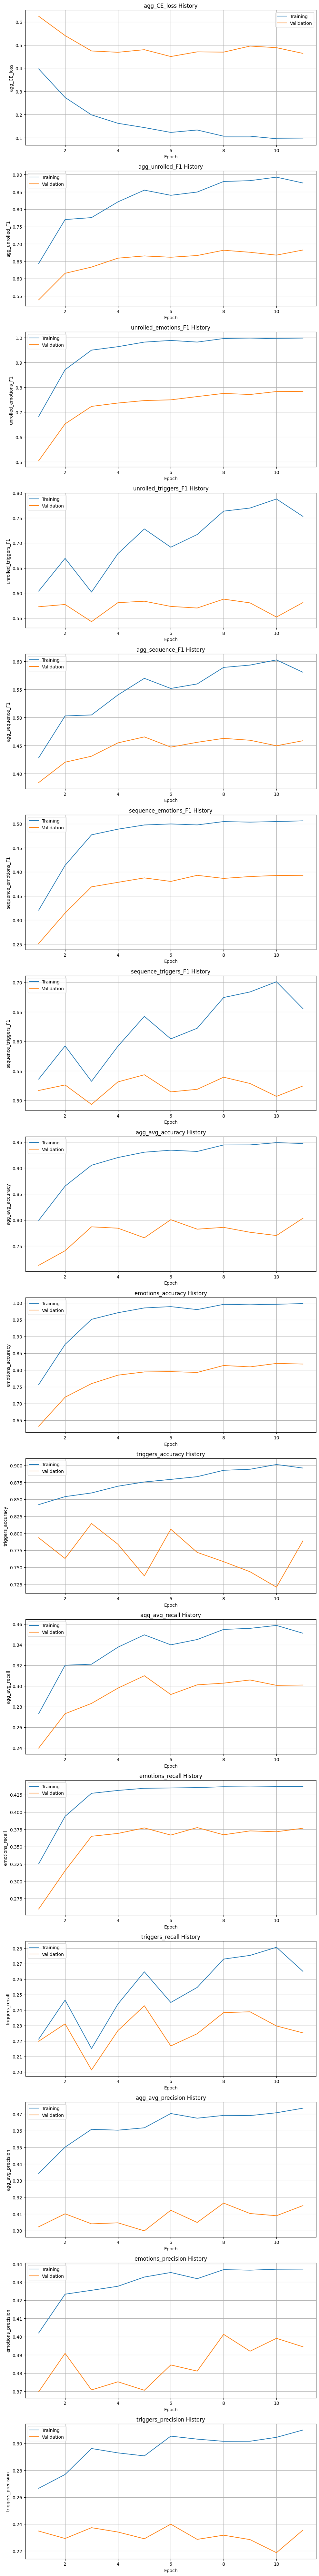

In [40]:
if FIT_FULL_BERTONE:
    plot_history(full_bertOne_history)
else:
    print('To show the training history of Full BERT base model you should set the flag FIT_FULL_BERTONE=True')
    

##### Full BertOne in inference mode and scores calculus


In [41]:
if RUN_FULL_BERTONE_PREDICT:

    pred = full_bertOne.predict(data=test_dataloader_full, model_output_function_transformation=torch.argmax)
    
    full_bertOne_results_df = test_df.copy()
    full_bertOne_results_df['pred_emotions'] = [[IDX_TO_EMOTIONS[emotion] for emotion in utterance_emotions] for utterance_emotions in pred['emotions'].tolist()]
    full_bertOne_results_df['pred_triggers'] =  pred['triggers'].tolist()
    
    max_length = len(full_bertOne_results_df.iloc[0]['pred_emotions'])
    full_bertOne_results_df['padded_emotions'] = full_bertOne_results_df['emotions'].apply(lambda x: x + ['z_emotion'] * (max_length - len(x)))
    full_bertOne_results_df['padded_triggers'] = full_bertOne_results_df['triggers'].apply(lambda x: x + [2] * (max_length - len(x)))
    

    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(padded_emotions),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[7])     
    
    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(padded_triggers),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[2])     
    
    
    full_bertOne_unrolled_emotions_f1, full_bertOne_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                               trigger_f1=trigger_f1, 
                                                                                               targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                                                               predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                                                               targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                                                               predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                                                               emotion_to_index=EMOTIONS_TO_IDX)
    
    full_bertOne_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                               trigger_f1=trigger_f1, 
                                                               targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                               predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                               targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                               predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                               emotion_to_index=EMOTIONS_TO_IDX)
    
    # Setting metric objects in none mode in order to compute the score for each class
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    full_bertOne_emotions_f1_per_class, full_bertOne_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                 trigger_f1=trigger_f1, 
                                                                                                 targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                                                                 predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                                                                 targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                                                                 predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                                                                 emotion_to_index=EMOTIONS_TO_IDX)
     
     
    full_bertOne_results_df.drop(columns=['padded_emotions', 'padded_triggers'], inplace=True)
    full_bertOne_results_df['pred_emotions'] = full_bertOne_results_df.apply(lambda row: row['pred_emotions'][:len(row['emotions'])], axis=1)
    full_bertOne_results_df['pred_triggers'] = full_bertOne_results_df.apply(lambda row: row['pred_triggers'][:len(row['triggers'])], axis=1)

    
    full_bertOne_unrolled_and_sequence_f1_df = pd.DataFrame(data={'full_bertone_cls_scores':[full_bertOne_unrolled_emotions_f1, 
                                                                                             full_bertOne_unrolled_triggers_f1, 
                                                                                             full_bertOne_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                             full_bertOne_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                            index=['unrolled emotion F1 scores', 
                                                                   'unrolled trigger F1 scores', 
                                                                   'sequence emotion F1 score', 
                                                                   'sequence trigger F1 score'])            
     
    
    full_bertOne_emotions_f1_per_class_df = pd.DataFrame(full_bertOne_emotions_f1_per_class, index=EMOTIONS, columns=['full_bertOne_scores'])
    full_bertOne_triggers_f1_per_class_df = pd.DataFrame(full_bertOne_triggers_f1_per_class,columns=['full_bertOne_scores'] )
    
    full_bertOne_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    
    full_bertOne_results_df.index.name = 'index'
    full_bertOne_f1_per_dialogue_df.index.name = 'episode'
    full_bertOne_unrolled_and_sequence_f1_df.index.name = 'metrics'
    full_bertOne_emotions_f1_per_class_df.index.name = 'emotions'
    full_bertOne_triggers_f1_per_class_df.index.name = 'triggers'
    full_bertOne_f1_per_dialogue_df.columns = ['full_bertOne_'+ c_n for c_n in full_bertOne_f1_per_dialogue_df.columns]
    
     # Saving Full bertOne results  
    full_bertOne_results_df.to_csv(FULL_BERTONE_PREDICTIONS_DF_PATH)
    full_bertOne_f1_per_dialogue_df.to_csv(FULL_BERTONE_F1_DIALOGUE_DF_PATH)
    full_bertOne_unrolled_and_sequence_f1_df.to_csv(FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    full_bertOne_emotions_f1_per_class_df.to_csv(FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH)
    full_bertOne_triggers_f1_per_class_df.to_csv(FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH)

else:
    # Loading Full bertOne results  
    full_bertOne_results_df = pd.read_csv(FULL_BERTONE_PREDICTIONS_DF_PATH, index_col=0)
    full_bertOne_f1_per_dialogue_df = pd.read_csv(FULL_BERTONE_F1_DIALOGUE_DF_PATH, index_col=0)
    full_bertOne_unrolled_and_sequence_f1_df = pd.read_csv(FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    full_bertOne_emotions_f1_per_class_df = pd.read_csv(FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    full_bertOne_triggers_f1_per_class_df = pd.read_csv(FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    
    
# Merging Full BertOne results to de file result dfs    
f1_per_dialogue_df = f1_per_dialogue_df.merge(full_bertOne_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(full_bertOne_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(full_bertOne_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(full_bertOne_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)


# Extracting the two worst dialogues for Full BertOne
interesting_dialogue_index_to_see += full_bertOne_f1_per_dialogue_df.sort_values(by=['full_bertOne_emotion_f1', 'full_bertOne_trigger_f1']).index[:2].tolist()


## Results

Comparison of Unrolled and Sequence F1 results for our models:


,random_cls_scores,majority_cls_scores,freezed_bertone_cls_scores,full_bertone_cls_scores
metrics,,,,
sequence emotion F1 score,0.075532,0.079494,0.339234,0.335338
sequence trigger F1 score,0.409933,0.437511,0.428564,0.478714
unrolled emotion F1 scores,0.128800,0.085537,0.633179,0.640093
unrolled trigger F1 scores,0.432276,0.456535,0.446217,0.511939


Focus on Unrolled F1 results on the different classes for our models:


,random_scores,majority_scores,freezed_bertOne_scores,full_bertOne_scores
emotions,,,,
anger,0.142549,0.000000,0.639715,0.627100
disgust,0.063492,0.000000,0.502674,0.562814
fear,0.068536,0.000000,0.637931,0.602041
joy,0.156977,0.000000,0.601892,0.608770
neutral,0.198405,0.598759,0.795729,0.776494
sadness,0.109804,0.000000,0.571895,0.607004
surprise,0.161838,0.000000,0.682420,0.696429


,random_scores,majority_scores,freezed_bertOne_scores,full_bertOne_scores
triggers,,,,
0,0.621842,0.91307,0.587753,0.736801
1,0.242710,0.00000,0.304682,0.287076


Focus on F1 results for each dialogue for our models:


,random_emotion_f1,random_trigger_f1,majority_emotion_f1,majority_trigger_f1,freezed_bertOne_emotion_f1,freezed_bertOne_trigger_f1,full_bertOne_emotion_f1,full_bertOne_trigger_f1
episode,,,,,,,,
utterance_1,0.000000,0.222222,0.131868,0.461538,0.272727,0.533333,0.272727,0.416667
utterance_1016,0.081633,0.285714,0.025974,0.500000,0.590476,0.285714,0.352381,0.333333
utterance_1020,0.142857,0.333333,0.040816,0.500000,0.257143,0.142857,0.224490,0.400000
utterance_1021,0.142857,0.300000,0.063492,0.461538,0.257143,0.285714,0.224490,0.650000
utterance_1028,0.114286,0.272727,0.057143,0.483871,0.440476,0.287449,0.390847,0.500000
...,...,...,...,...,...,...,...,...
utterance_960,0.000000,1.000000,0.071429,0.400000,0.428571,0.666667,0.428571,0.666667
utterance_972,0.000000,0.363636,0.063492,0.500000,0.571429,0.300000,0.400000,0.300000
utterance_975,0.000000,0.000000,0.071429,0.250000,0.142857,1.000000,0.238095,0.666667


Focus on the worst two prediction for our models
Random CLS
Utterance 880


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,surprise,"So! I'm just an empty vase, huh?",0,anger,1
1,Julio,surprise,What?,0,neutral,1
2,Monica,anger,"Y'know, so I don't read as many important book...",1,joy,0



Majority CLS
Utterance 880


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,surprise,"So! I'm just an empty vase, huh?",0,neutral,0
1,Julio,surprise,What?,0,neutral,0
2,Monica,anger,"Y'know, so I don't read as many important book...",1,neutral,0



Freezed BertOne
Utterance 880


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,surprise,"So! I'm just an empty vase, huh?",0,sadness,1
1,Julio,surprise,What?,0,surprise,0
2,Monica,anger,"Y'know, so I don't read as many important book...",1,anger,1



Full BertOne
Utterance 880


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,surprise,"So! I'm just an empty vase, huh?",0,anger,1
1,Julio,surprise,What?,0,surprise,0
2,Monica,anger,"Y'know, so I don't read as many important book...",1,anger,0



Random CLS
Utterance 2454


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,neutral,It's not just the drum noise.,1,disgust,0
1,Monica,anger,"Every five minutes, Joey throws his sticks in ...",1,disgust,0



Majority CLS
Utterance 2454


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,neutral,It's not just the drum noise.,1,neutral,0
1,Monica,anger,"Every five minutes, Joey throws his sticks in ...",1,neutral,0



Freezed BertOne
Utterance 2454


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,neutral,It's not just the drum noise.,1,neutral,1
1,Monica,anger,"Every five minutes, Joey throws his sticks in ...",1,disgust,1



Full BertOne
Utterance 2454


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,neutral,It's not just the drum noise.,1,surprise,0
1,Monica,anger,"Every five minutes, Joey throws his sticks in ...",1,anger,1



Random CLS
Utterance 3459


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,sadness,0
1,Ross,surprise,These pants are burning up!,1,neutral,0
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,joy,0
3,Ross,anger,What is she trying to kill me?,1,surprise,0
4,Ross,surprise,It's like a volcano in here!,1,joy,0



Majority CLS
Utterance 3459


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,neutral,0
1,Ross,surprise,These pants are burning up!,1,neutral,0
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,neutral,0
3,Ross,anger,What is she trying to kill me?,1,neutral,0
4,Ross,surprise,It's like a volcano in here!,1,neutral,0



Freezed BertOne
Utterance 3459


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,surprise,0
1,Ross,surprise,These pants are burning up!,1,sadness,1
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,joy,1
3,Ross,anger,What is she trying to kill me?,1,sadness,1
4,Ross,surprise,It's like a volcano in here!,1,surprise,1



Full BertOne
Utterance 3459


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,surprise,0
1,Ross,surprise,These pants are burning up!,1,sadness,1
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,neutral,0
3,Ross,anger,What is she trying to kill me?,1,sadness,1
4,Ross,surprise,It's like a volcano in here!,1,surprise,0



Random CLS
Utterance 3458


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,anger,0
1,Ross,surprise,These pants are burning up!,1,joy,1
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,disgust,0
3,Ross,anger,What is she trying to kill me?,1,disgust,1



Majority CLS
Utterance 3458


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,neutral,0
1,Ross,surprise,These pants are burning up!,1,neutral,0
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,neutral,0
3,Ross,anger,What is she trying to kill me?,1,neutral,0



Freezed BertOne
Utterance 3458


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,surprise,0
1,Ross,surprise,These pants are burning up!,1,sadness,1
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,joy,1
3,Ross,anger,What is she trying to kill me?,1,sadness,1



Full BertOne
Utterance 3458


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,surprise,My God!,0,surprise,0
1,Ross,surprise,These pants are burning up!,1,sadness,1
2,Ross,surprise,"Oh come on, she wants to snuggle now!",1,neutral,0
3,Ross,anger,What is she trying to kill me?,1,sadness,1



Random CLS
Utterance 2255


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,There he is! There he is!,0,fear,0
1,Monica,neutral,Where?,1,joy,1
2,Phoebe,joy,Right- where we've been looking all night!,0,fear,1



Majority CLS
Utterance 2255


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,There he is! There he is!,0,neutral,0
1,Monica,neutral,Where?,1,neutral,0
2,Phoebe,joy,Right- where we've been looking all night!,0,neutral,0



Freezed BertOne
Utterance 2255


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,There he is! There he is!,0,joy,1
1,Monica,neutral,Where?,1,surprise,0
2,Phoebe,joy,Right- where we've been looking all night!,0,neutral,1



Full BertOne
Utterance 2255


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,There he is! There he is!,0,joy,0
1,Monica,neutral,Where?,1,surprise,0
2,Phoebe,joy,Right- where we've been looking all night!,0,joy,0



Random CLS
Utterance 3643


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,Great nap.,1,neutral,1
1,Ross,neutral,It really was.,1,fear,1
2,Joey,joy,"Uh me? Gay? No! No. No, but I have a number of...",0,sadness,1



Majority CLS
Utterance 3643


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,Great nap.,1,neutral,0
1,Ross,neutral,It really was.,1,neutral,0
2,Joey,joy,"Uh me? Gay? No! No. No, but I have a number of...",0,neutral,0



Freezed BertOne
Utterance 3643


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,Great nap.,1,joy,0
1,Ross,neutral,It really was.,1,joy,0
2,Joey,joy,"Uh me? Gay? No! No. No, but I have a number of...",0,surprise,1



Full BertOne
Utterance 3643


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,Great nap.,1,neutral,0
1,Ross,neutral,It really was.,1,joy,0
2,Joey,joy,"Uh me? Gay? No! No. No, but I have a number of...",0,surprise,1



Random CLS
Utterance 418


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Rachel,fear,"Monica, betting the apartment, I don't know ab...",1,neutral,1
1,Monica,joy,"Rachel, I have not missed one question the who...",0,sadness,0
2,Rachel,surprise,Why? Do you have the answers written on there?,0,joy,0
3,Monica,neutral,"No! Steady as a rock! Now, are you with me.",0,sadness,1
4,Rachel,fear,"All right, let's do it.",1,joy,1



Majority CLS
Utterance 418


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Rachel,fear,"Monica, betting the apartment, I don't know ab...",1,neutral,0
1,Monica,joy,"Rachel, I have not missed one question the who...",0,neutral,0
2,Rachel,surprise,Why? Do you have the answers written on there?,0,neutral,0
3,Monica,neutral,"No! Steady as a rock! Now, are you with me.",0,neutral,0
4,Rachel,fear,"All right, let's do it.",1,neutral,0



Freezed BertOne
Utterance 418


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Rachel,fear,"Monica, betting the apartment, I don't know ab...",1,fear,1
1,Monica,joy,"Rachel, I have not missed one question the who...",0,joy,1
2,Rachel,surprise,Why? Do you have the answers written on there?,0,neutral,1
3,Monica,neutral,"No! Steady as a rock! Now, are you with me.",0,joy,1
4,Rachel,fear,"All right, let's do it.",1,neutral,0



Full BertOne
Utterance 418


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Rachel,fear,"Monica, betting the apartment, I don't know ab...",1,neutral,0
1,Monica,joy,"Rachel, I have not missed one question the who...",0,neutral,1
2,Rachel,surprise,Why? Do you have the answers written on there?,0,neutral,0
3,Monica,neutral,"No! Steady as a rock! Now, are you with me.",0,joy,0
4,Rachel,fear,"All right, let's do it.",1,neutral,0



Random CLS
Utterance 1438


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,neutral,And here we go,0,fear,1
1,Joey,disgust,I saw this movie once where there was a door a...,0,fear,0
2,Joey,joy,Y'know it wouldn't kill ya to respect your wif...,0,disgust,1



Majority CLS
Utterance 1438


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,neutral,And here we go,0,neutral,0
1,Joey,disgust,I saw this movie once where there was a door a...,0,neutral,0
2,Joey,joy,Y'know it wouldn't kill ya to respect your wif...,0,neutral,0



Freezed BertOne
Utterance 1438


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,neutral,And here we go,0,anger,1
1,Joey,disgust,I saw this movie once where there was a door a...,0,joy,1
2,Joey,joy,Y'know it wouldn't kill ya to respect your wif...,0,joy,1



Full BertOne
Utterance 1438


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,neutral,And here we go,0,anger,0
1,Joey,disgust,I saw this movie once where there was a door a...,0,joy,0
2,Joey,joy,Y'know it wouldn't kill ya to respect your wif...,0,anger,0



Confusion matrices for our models


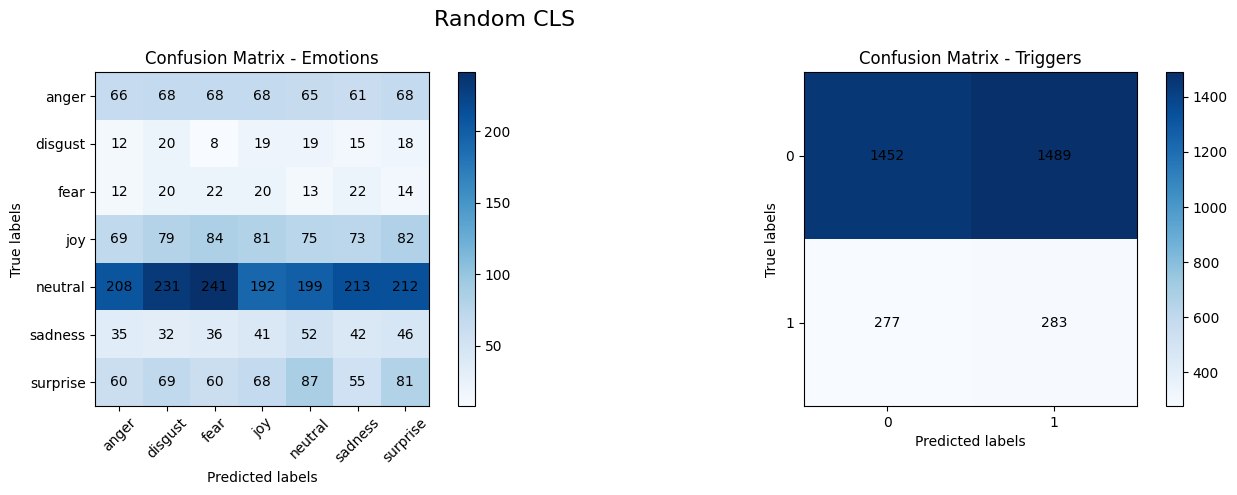

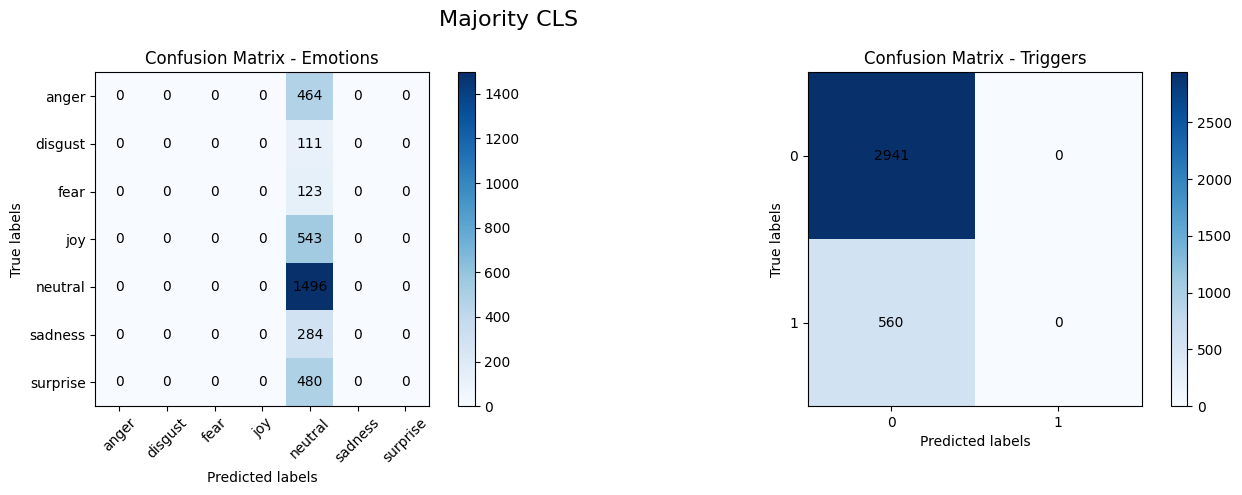

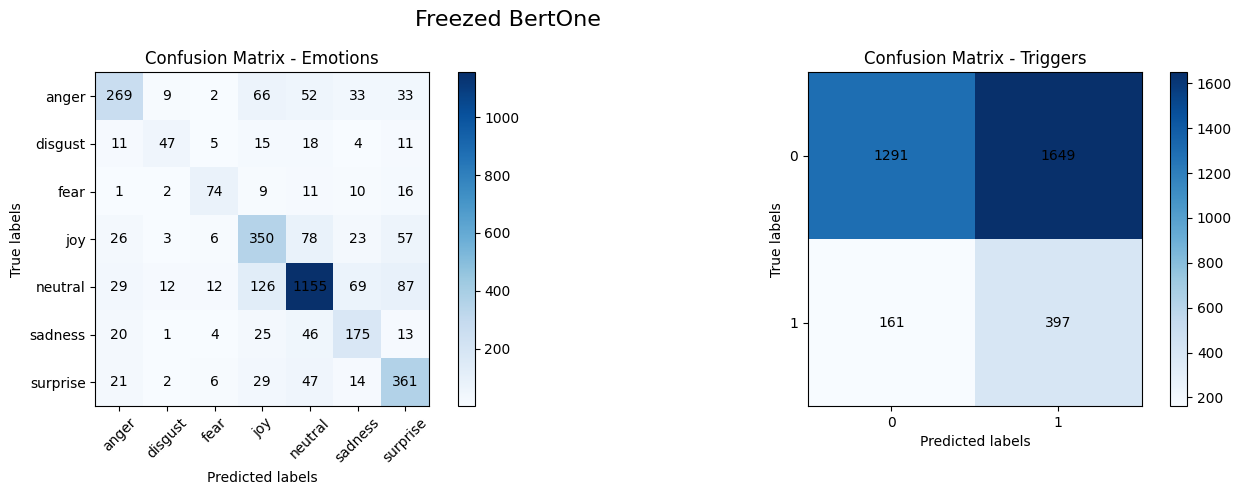

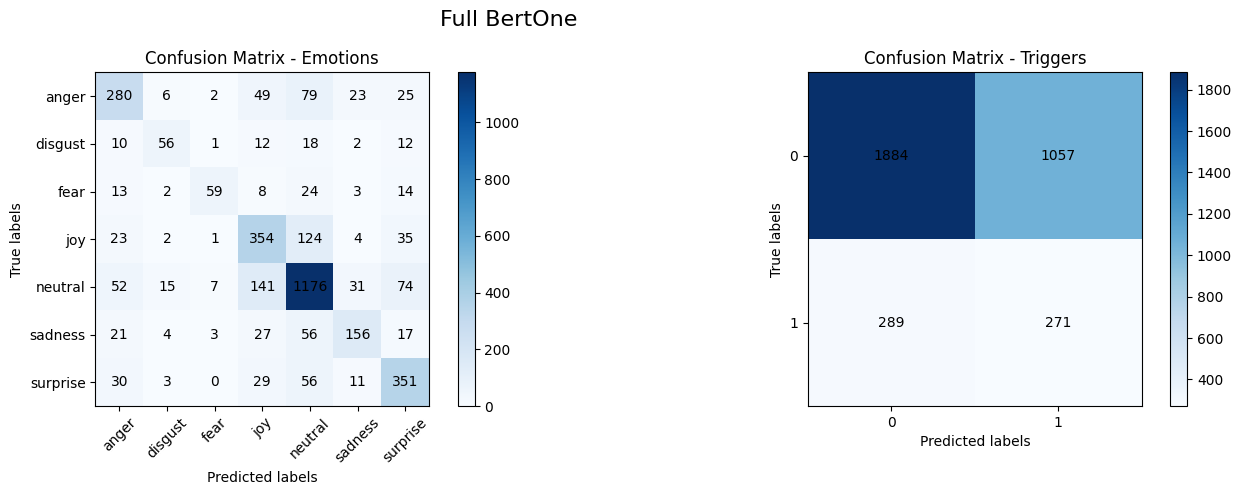

In [42]:
print('Comparison of Unrolled and Sequence F1 results for our models:')
display(unrolled_and_sequence_f1_df)
print('Focus on Unrolled F1 results on the different classes for our models:')
display(emotions_f1_per_class_df)
display(triggers_f1_per_class_df)
print('Focus on F1 results for each dialogue for our models:')
display(f1_per_dialogue_df)

print('Focus on the worst two prediction for our models')

for index in interesting_dialogue_index_to_see:
    
    if random_clf_results_df is not None:
        print('Random CLS')
        display_dialogue(dataframe=random_clf_results_df, utterance_id=index)
    if majority_clf_results_df is not None:
        print('Majority CLS')
        display_dialogue(dataframe=majority_clf_results_df, utterance_id=index)
    print('Freezed BertOne')
    display_dialogue(dataframe=freezed_bertOne_results_df, utterance_id=index)
    print('Full BertOne')
    display_dialogue(dataframe=full_bertOne_results_df, utterance_id=index)
    
print('Confusion matrices for our models')


plot_confusion_matrix(target_emotions=random_clf_results_df['emotions'], 
                      pred_emotions=random_clf_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=random_clf_results_df['triggers'], 
                      pred_triggers=random_clf_results_df['pred_triggers'],
                      title='Random CLS')

plot_confusion_matrix(target_emotions=majority_clf_results_df['emotions'], 
                      pred_emotions=majority_clf_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=majority_clf_results_df['triggers'], 
                      pred_triggers=majority_clf_results_df['pred_triggers'],
                      title='Majority CLS')

plot_confusion_matrix(target_emotions=freezed_bertOne_results_df['emotions'], 
                      pred_emotions=freezed_bertOne_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=freezed_bertOne_results_df['triggers'], 
                      pred_triggers=freezed_bertOne_results_df['pred_triggers'],
                      title='Freezed BertOne')

plot_confusion_matrix(target_emotions=full_bertOne_results_df['emotions'], 
                      pred_emotions=full_bertOne_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=full_bertOne_results_df['triggers'], 
                      pred_triggers=full_bertOne_results_df['pred_triggers'],
                      title='Full BertOne')



## Further experiments

### Applying some preprocessing operations 


In [ ]:
df['speaker_and_utterances'] = [[speaker[i] + ': ' + utterance[i] for i in range(len(speaker))] for speaker,utterance in zip(df['speakers'],df['utterances'])]


### Dataloaders creation

In [ ]:
max_tokenized_length_su = find_max_encoded_utterance_len(bert_tokenizer, df['speaker_and_utterances'])
my_tokenization_f_su = partial(tokenize_data, max_tokenized_length=max_tokenized_length_su, tokenizer=bert_tokenizer)

# BertFreezed Dataloaders
train_dataloader_freezed_su = dataLoaderBuilder.create(data=train_df['speaker_and_utterances'],
                                                       labels=train_df[['emotions', 'triggers']],
                                                       shuffle=True,
                                                       data_preprocess_f=my_tokenization_f_su,
                                                       labels_preprocess_f=preprocess_labels,
                                                       batch_size=32,
                                                       device=device)
 
val_dataloader_freezed_su = dataLoaderBuilder.create(data=val_df['speaker_and_utterances'],
                                                     labels=val_df[['emotions', 'triggers']],
                                                     shuffle=False,
                                                     data_preprocess_f=my_tokenization_f_su,
                                                     labels_preprocess_f=preprocess_labels,
                                                     batch_size=32,
                                                     device=device)
 
test_dataloader_freezed_su = dataLoaderBuilder.create(data=test_df['speaker_and_utterances'],
                                                      labels=test_df[['emotions', "triggers"]],
                                                      shuffle=False,
                                                      data_preprocess_f=my_tokenization_f_su,
                                                      labels_preprocess_f=preprocess_labels,
                                                      batch_size=32,
                                                      device=device)


# BertFull Dataloaders
train_dataloader_full_su = dataLoaderBuilder.create(data=train_df['speaker_and_utterances'],
                                                    labels=train_df[['emotions', 'triggers']],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f_su,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=2,
                                                    device=device)
 
val_dataloader_full_su = dataLoaderBuilder.create(data=val_df['speaker_and_utterances'],
                                                  labels=val_df[['emotions', 'triggers']],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f_su,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=2,
                                                  device=device)
 
test_dataloader_full_su = dataLoaderBuilder.create(data=test_df['speaker_and_utterances'],
                                                   labels=test_df[['emotions', 'triggers']],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f_su,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=2,
                                                   device=device)


input_data_freezed_su, _ = next(iter(train_dataloader_freezed_su))
input_data_full_su, _ = next(iter(train_dataloader_full_su))

n_token_per_utterance_su = input_data_freezed_su['input_ids'].shape[-1]

In [ ]:
# todo inserire i test aggiungendo gli speaker
# todo aggiungere i test mettendo i linear layer aggiuntivi
# todo aggiungere tutti i test del mondo

### Big BertOne


#### Downloading/Reloading longformer-base-4096


In [26]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BIG_BERT_DIRECTORY):
    big_bert_model, big_bert_tokenizer = retrieve_bert_initializers(bert_constructor=LongformerModel, 
                                                                    bert_tokenizer_constructor=LongformerTokenizer,
                                                                    bert_path=BIG_BERT_DIRECTORY) 
else:
    big_bert_model, big_bert_tokenizer = download_bert_initializers(bert_constructor=LongformerModel, 
                                                                bert_tokenizer_constructor=LongformerTokenizer,
                                                                bert_path=BIG_BERT_DIRECTORY,
                                                                version='allenai/longformer-base-4096')

In [27]:
def tokenize_data_2(data: pd.Series, max_tokenized_length: int, tokenizer: transformers.BartTokenizer) -> Dict[str, torch.Tensor]:
    """
    Tokenize a pandas Series of text data.

    :params data: A pandas Series containing text data.
    :params max_tokenized_length: The maximum lang of the tokenized sentence.
    :params tokenizer: Bert tokenizer.

    :returns: A dictionary containing tokenized input, attention masks, and token type IDs.

    """

    input_ids_list = []
    attention_masks_list = []
    token_type_ids_list = []

    for text_list in data:
        tokenized_utterances = tokenizer.batch_encode_plus(batch_text_or_text_pairs=text_list,
                                                           padding="max_length",
                                                           max_length=max_tokenized_length,
                                                           return_tensors='pt')

        input_ids, attention_mask = remove_redundant_cls2(tokenized_utterances['input_ids'],
                                                          tokenized_utterances['attention_mask'])

        input_ids_list.append(input_ids)
        attention_masks_list.append(attention_mask)

    padded_input_ids = pad_utterances(input_ids_list, tokenizer.pad_token_id)
    padded_attention_masks = pad_utterances(attention_masks_list, 0)

    output = {'input_ids': padded_input_ids,
              'attention_mask': padded_attention_masks}

    return output

def remove_redundant_cls2(input_ids: torch.Tensor, attention_mask: torch.Tensor):
    """
    Removes the redundant [CLS] token from the input tensors.


    :params input_ids (torch.Tensor): Tensor containing the input token IDs.
    :params attention_mask (torch.Tensor): Tensor containing the attention mask.
    :params token_type_ids (torch.Tensor): Tensor containing the token type IDs.

    :returns:
        tuple: A tuple containing the modified input tensors:
            - input_ids (torch.Tensor): Tensor containing the input token IDs with the first [CLS] token removed.
            - attention_mask (torch.Tensor): Tensor containing the attention mask with the first [CLS] token removed.
            - token_type_ids (torch.Tensor): Tensor containing the token type IDs with the first [CLS] token removed.

    """

    pad = torch.zeros(input_ids.shape[0] - 1)

    input_ids[1:, 0] = pad
    attention_mask[1:, 0] = pad

    return input_ids, attention_mask

def send_a_predicted_sample_to_wandb_2(model: BertOne):
    """
    An auxiliary function used to send Wandb the predictions of an element extracted from the test set during training 
    to monitor how the model's predictions improve during the during various epochs  
        
    """
    
    model.eval()

    sample_to_send = test_df.iloc[0].copy()
    input  = next(iter(test_dataloader_big))[0]
    input = {key:input[key][0].unsqueeze(0).to(device) for key in input.keys()}
    prediction = model(input)
    prediction = {key: torch.argmax(prediction[key], dim=-1).view(-1).detach().cpu() for key in prediction.keys()}
    
    table_data = []
    for column_value in sample_to_send:
        table_data.append(column_value)
    
    new_df = pd.DataFrame(table_data).transpose()
    new_df.columns = sample_to_send.index
    
    new_df['pred_emotion'] = [IDX_TO_EMOTIONS[emotion] for emotion in prediction['emotions'].tolist()][: len(new_df)]
    new_df['pred_emotion'] = new_df['pred_emotion'].apply(lambda x: str(x))

    new_df['pred_triggers'] = prediction['triggers'].tolist()[: len(new_df)]
    
    return {'sample_of_predictions': wandb.Table(dataframe=new_df)}


#### Data Loaders creation


In [28]:
torch.manual_seed(SEED)
np.random.seed(SEED)


dataLoaderBuilder = DataLoaderFromPipelineStrategy()

max_tokenized_length =  find_max_encoded_utterance_len(big_bert_tokenizer, df['utterances'])

my_tokenization_f = partial(tokenize_data_2, max_tokenized_length=max_tokenized_length,tokenizer=big_bert_tokenizer)


# BigBertOne Dataloaders
train_dataloader_big = dataLoaderBuilder.create(data=train_df['utterances'],
                                                labels=train_df[['emotions', 'triggers']],
                                                shuffle=True,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=BATCH_SIZE_BIG,
                                                device=device)

val_dataloader_big = dataLoaderBuilder.create(data=val_df['utterances'],
                                              labels=val_df[['emotions', 'triggers']],
                                              shuffle=False,
                                              data_preprocess_f=my_tokenization_f,
                                              labels_preprocess_f=preprocess_labels,
                                              batch_size=BATCH_SIZE_BIG,
                                              device=device)
 
test_dataloader_big = dataLoaderBuilder.create(data=test_df['utterances'],
                                               labels=test_df[['emotions', 'triggers']],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=BATCH_SIZE_BIG,
                                               device=device)   


 
input_data_freezed, _ = next(iter(train_dataloader_big))

n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


#### Creating Big BertOne


In [29]:
torch.manual_seed(SEED)
np.random.seed(SEED)

big_bertOne = BigBertOne(bert_model=big_bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                         hidden_dim=512,
                         freeze_bert_weights=True,
                         name='BigBertOne').to(device)


#### Fitting Big BertOne


In [ ]:
import logging
if FIT_BIG_BERTONE: 
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)
    
    
    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                       'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    

    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={1e-3}', 
                                 optimizer_partial_params={'lr': 1e-3})  
    
    
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
    
    big_bertOne_history = big_bertOne.fit(train_loader=train_dataloader_big,
                                          val_loader=val_dataloader_big,
                                          criterion=multi_head_criterion,
                                          metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                          optimizer=optimizer,
                                          early_stopper=multiple_stopper,
                                          num_epochs=MAX_N_EPOCH,
                                          verbose=2,
                                          interaction_with_wandb=INTERACT_WITH_WANDB,
                                          interaction_function_with_wandb=send_a_predicted_sample_to_wandb_2)

    torch.save(big_bertOne.state_dict(), BIG_BERTONE_WEIGHTS_PATH)

else:
    big_bertOne.load_state_dict(torch.load(BIG_BERTONE_WEIGHTS_PATH))
    
    big_bertOne_history = None 
    

wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch: 1/50 Iterations: 376/400 - CE_loss: 0.7601556765 - unrolled_emotions_F1: 0.2616334283 - unrolled_triggers_F1: 0.4193548387 - agg_unrolled_F1: 0.3404941335 - sequence_emotions_F1: 0.1868197279 - sequence_triggers_F1: 0.4047243266 - agg_sequence_F1: 0.2957720272 - emotions_accuracy: 0.5555555556 - triggers_accuracy: 0.7222222222 - agg_avg_accuracy: 0.6388888889 - emotions_recall: 0.2614160034 - triggers_recall: 0.3270440252 - agg_avg_recall: 0.2942300143 - emotions_precision: 0.2141666667 - triggers_precision: 0.2441314554 - agg_avg_precision: 0.2291490610